# RUL Time Prediction for Turbofan Engine

## 1. Explaining the data set

- Engine degradation simulation was carried out for run-to-failure using C-MAPSS (Commercial Modular Aero-Propulsion System Simulation). 
 
- Four different data sets simulated under different combinations of operational conditions and fault modes. 
 
- Records several sensor channels to characterize fault evolution.

- The data sets consists of multivariate time series signals.

- There are 100 engines are considered in data set FD001. Each of the engines is operating normally at the start of each time series and develops a fault at some point during the series. The fault grows in magnitude until the system failure. 

-  Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user.

- Each record in run-to-failure trajectories, which corresponds to a given operation cycle, is a 24-element vector, consists of three values for the operational settings and 21 values for engine performance measurements, which are contaminated with noise.

- All failures are caused by High-Pressure Compressor (HPC) degradation. 


![1](https://user-images.githubusercontent.com/44237325/73242153-25f63580-41b5-11ea-97b9-9b64dea3a09b.png)

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import random
from random import randint
import importlib
import os
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
import itertools

In [2]:
#Loading the data set

columns = ['unit_nr', 'time', 'opset_1', 'opset_2', 'opset_3']
columns += ['sensor_{0:02d}'.format(s + 1) for s in range(21)]

df = pd.read_csv("train_FD001.txt", names = columns, delim_whitespace = True, header = None)
df_val = pd.read_csv("test_FD001.txt", names = columns, delim_whitespace = True, header = None)
RUL_1 = pd.read_csv("RUL_FD001.txt", names = ['RUL'], delim_whitespace = True, header = None)

In [3]:
df.columns

Index(['unit_nr', 'time', 'opset_1', 'opset_2', 'opset_3', 'sensor_01',
       'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06',
       'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'],
      dtype='object')

## 2. Performing exploratory statistical analysis on the data set

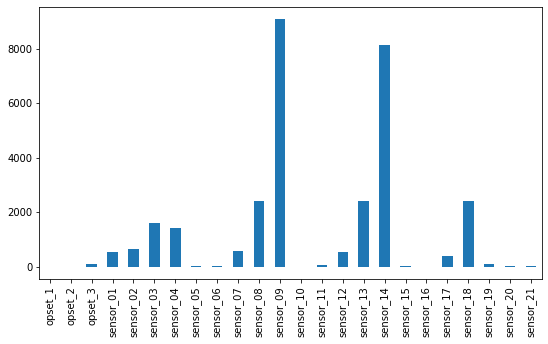

In [4]:
# Looking the mean of the features
df.iloc[:,2:].mean().plot.bar(figsize = (9,5))

Pearson correlation coefficient (PCC):

- PCC is a measure of the linear correlation between two variables X and Y.

## $\rho(X,Y)=\frac{cov(X,Y)}{\sigma X \sigma Y}$

Please note that:

 * Positive Correlation:  Both variables change in the same direction.
  
 * Neutral Correlation:   No relationship in the change of the variables.

 * Negative Correlation:  Variables change in opposite directions.

In [5]:
corr = df.copy()

del corr['unit_nr']

corr.set_index('time', inplace = True)
corr.dropna(axis = 1, how = 'all', inplace = True)

corr = corr.corr(method = 'pearson')
corr2 = pd.DataFrame(np.tril(corr.values), columns = corr.columns, index = corr.index)

correlating = []
for col in corr2.columns:
    ser = corr2[col]
    idx = np.logical_or(-0.8 > ser,  ser > 0.8)
    for i, c in zip(ser[idx].index, ser[idx].values):
        if (i, col, c) not in correlating and i != col:
            correlating.append((col, i, c.round(2)))

print('highly correlating measurements:')
for c in correlating:
    print(c) 

highly correlating measurements:
('sensor_01', 'sensor_05', 1.0)
('sensor_01', 'sensor_10', 1.0)
('sensor_01', 'sensor_16', 1.0)
('sensor_04', 'sensor_11', 0.83)
('sensor_04', 'sensor_12', -0.82)
('sensor_05', 'sensor_10', 1.0)
('sensor_05', 'sensor_16', 1.0)
('sensor_07', 'sensor_11', -0.82)
('sensor_07', 'sensor_12', 0.81)
('sensor_08', 'sensor_13', 0.83)
('sensor_09', 'sensor_14', 0.96)
('sensor_10', 'sensor_16', 1.0)
('sensor_11', 'sensor_12', -0.85)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EBC22A02B0>,
      dtype=object)

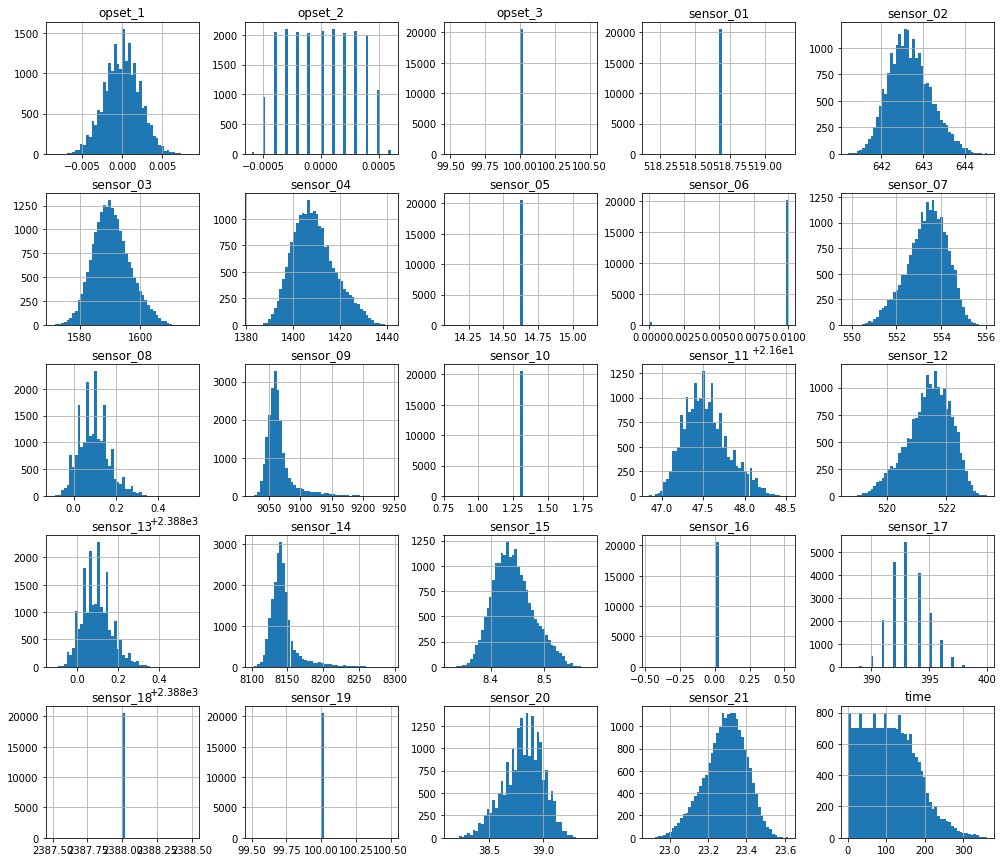

In [6]:
# Ploting the distribution of the all variables

df.iloc[:,1:].hist(bins = 50, figsize = (17,15))

In [7]:
dfv = pd.DataFrame(df.describe().transpose())
dfv[dfv['min']-dfv['max'] == 0]

count     mean           std      min      25%      50%      75%  \
opset_3    20631.0   100.00  0.000000e+00   100.00   100.00   100.00   100.00   
sensor_01  20631.0   518.67  6.537152e-11   518.67   518.67   518.67   518.67   
sensor_05  20631.0    14.62  3.394700e-12    14.62    14.62    14.62    14.62   
sensor_10  20631.0     1.30  4.660829e-13     1.30     1.30     1.30     1.30   
sensor_16  20631.0     0.03  1.556432e-14     0.03     0.03     0.03     0.03   
sensor_18  20631.0  2388.00  0.000000e+00  2388.00  2388.00  2388.00  2388.00   
sensor_19  20631.0   100.00  0.000000e+00   100.00   100.00   100.00   100.00   

               max  
opset_3     100.00  
sensor_01   518.67  
sensor_05    14.62  
sensor_10     1.30  
sensor_16     0.03  
sensor_18  2388.00  
sensor_19   100.00

## 3. Performing basic data visualization techniques on the dataset 

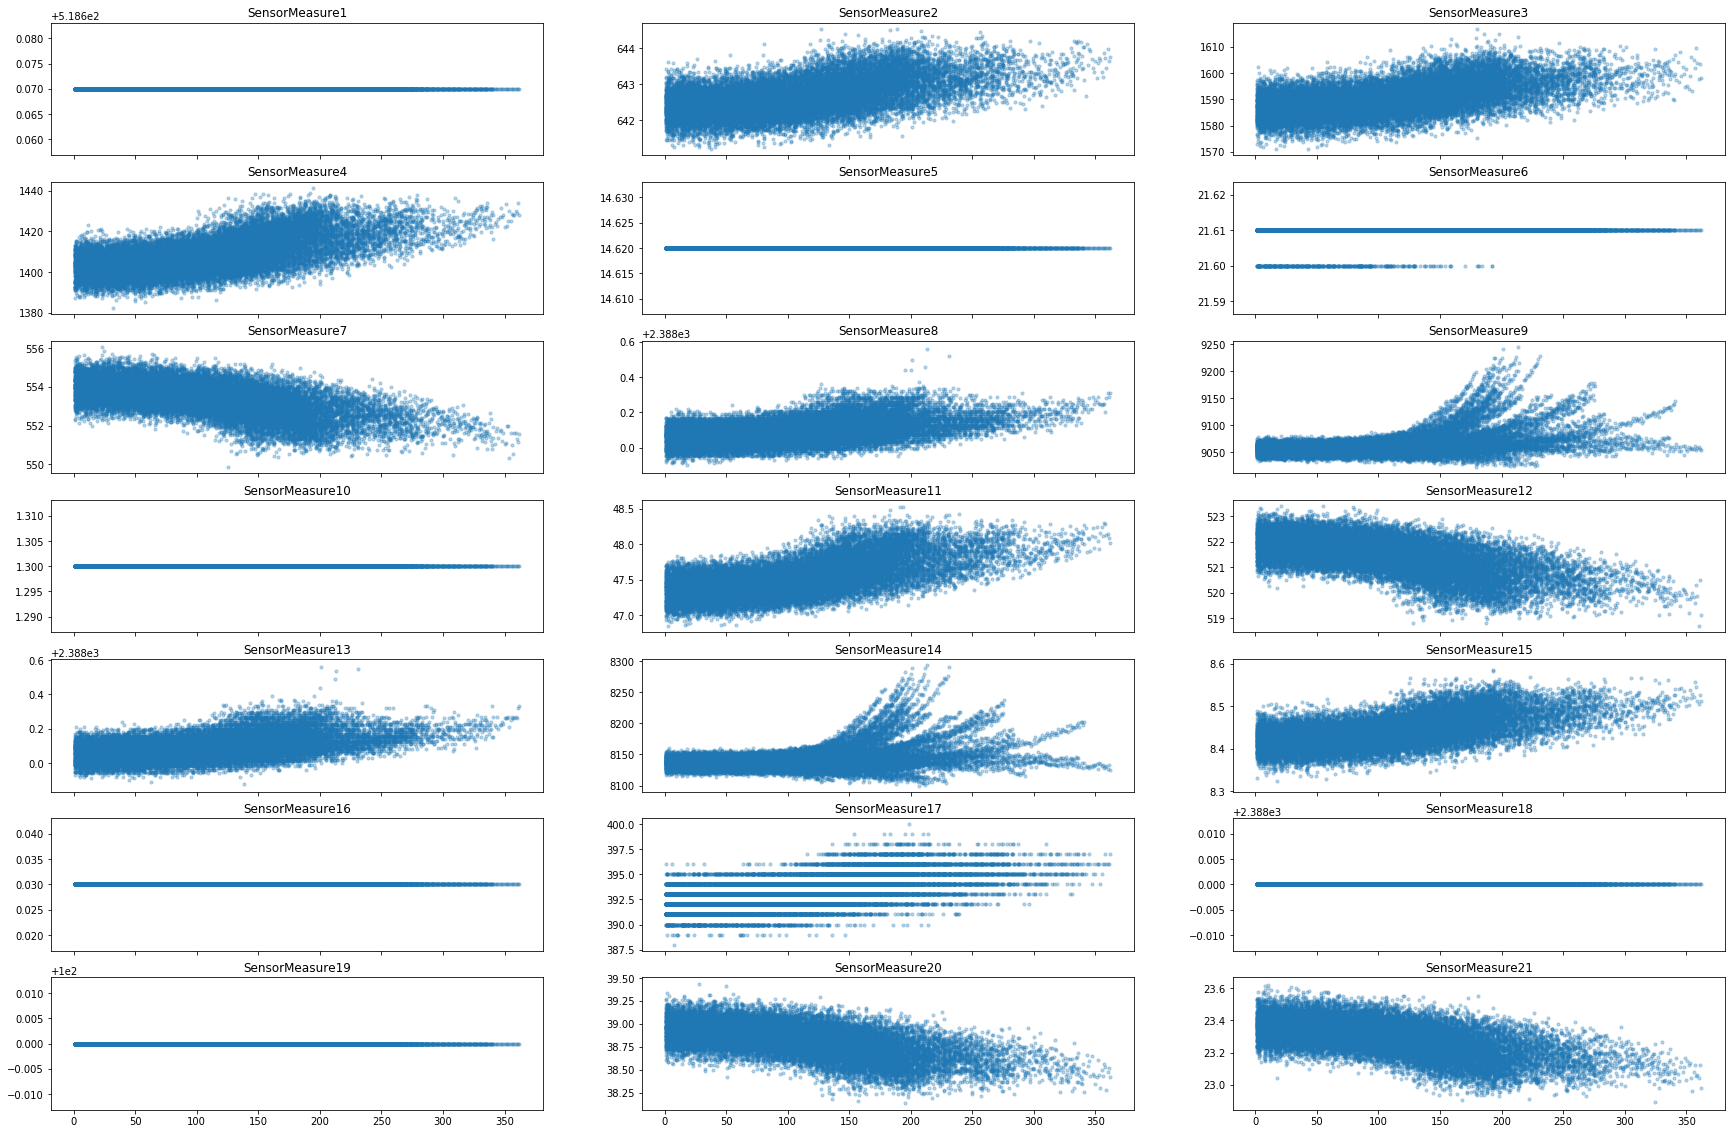

In [8]:
fig, ax = plt.subplots(7,3, figsize = (30,20), sharex = True)
c = 0
for i in range(0,7):
    for j in range(0,3):
        ax[i,j].scatter(df.time.values, df['sensor_{0:02d}'.format(c + 1)], s = 10, alpha = 0.3)
        ax[i,j].set_title('SensorMeasure' + str(c + 1))
        c += 1

In [9]:
# Excluding those columns with constant values from the dataset

df.drop(['sensor_01', 'sensor_05', 'sensor_06','sensor_09', 'sensor_10', 'sensor_14','sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'opset_3'], axis = 1, inplace = True)
df_val.drop(['sensor_01', 'sensor_05', 'sensor_06','sensor_09','sensor_10', 'sensor_14','sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'opset_3'], axis = 1, inplace = True)

In [10]:
df.columns

Index(['unit_nr', 'time', 'opset_1', 'opset_2', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_07', 'sensor_08', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_15', 'sensor_20', 'sensor_21'],
      dtype='object')

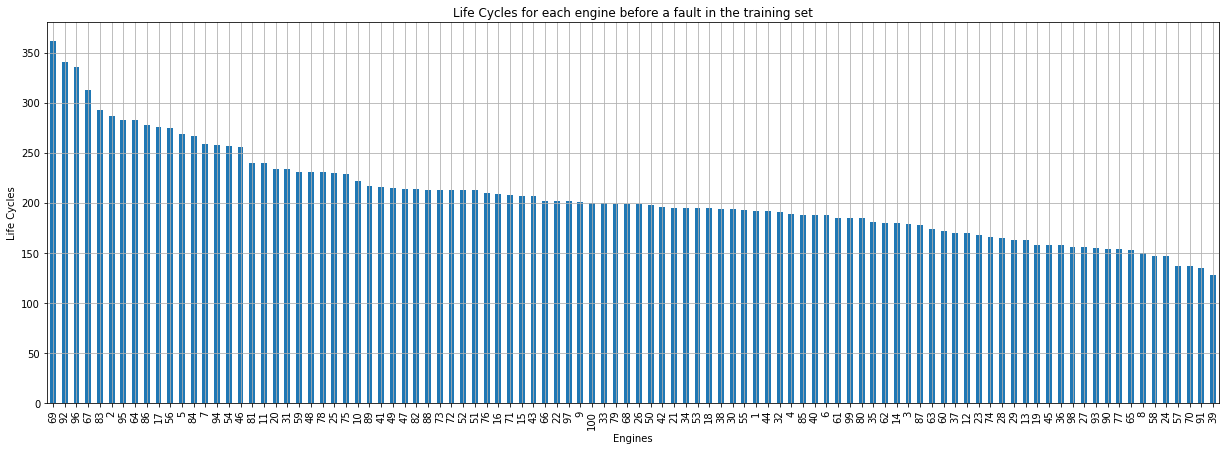

In [11]:
# Life Cycles for each engine before a fault in the training set in descending order
ax = df.unit_nr.value_counts().plot.bar(figsize=(21,7))
plt.title("Life Cycles for each engine before a fault in the training set")
ax.set_xlabel("Engines")
ax.set_ylabel("Life Cycles")
ax.grid()

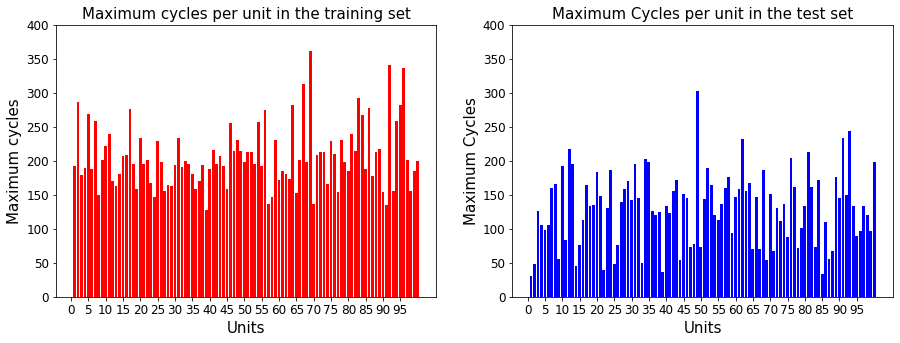

In [12]:
# Comparing the max cycles between the training and the test set

train_cycles = df.groupby('unit_nr', as_index = False)['time'].max()
test_cycles = df_val.groupby('unit_nr', as_index = False)['time'].max()
fig = plt.figure(figsize = (15,5))
fig.add_subplot(1,2,1)
bar_labels = list(train_cycles['unit_nr'])
bars = plt.bar(list(train_cycles['unit_nr']), train_cycles['time'], color = 'red')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize = 15)
plt.ylabel('Maximum cycles', fontsize = 15)
plt.title('Maximum cycles per unit in the training set', fontsize = 15)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize = 12)
plt.yticks(fontsize=12)
fig.add_subplot(1,2,2)
bars = plt.bar(list(test_cycles['unit_nr']), test_cycles['time'], color = 'blue')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize = 15)
plt.ylabel('Maximum Cycles', fontsize = 15)
plt.title('Maximum Cycles per unit in the test set', fontsize = 15)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

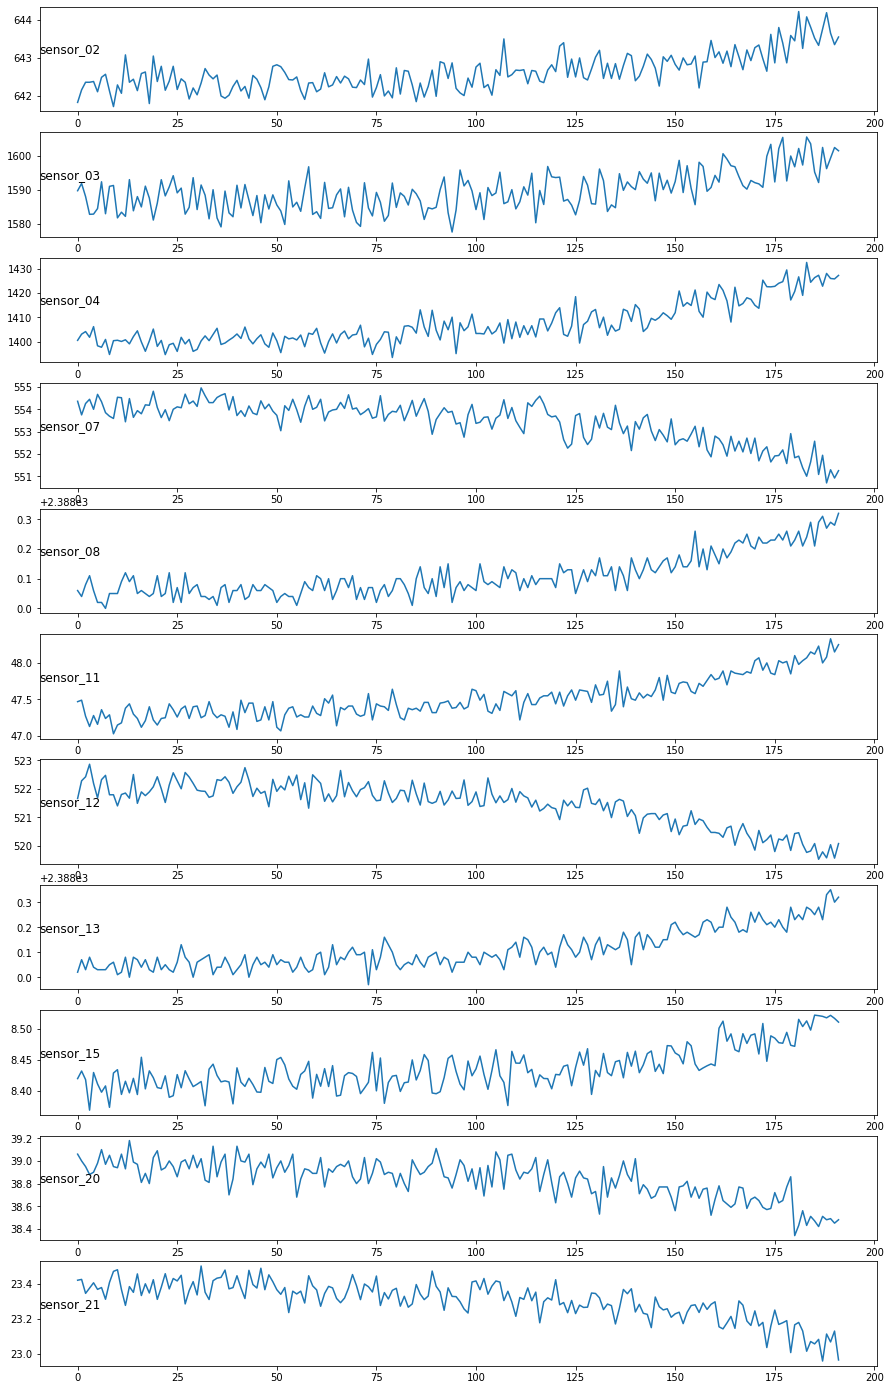

In [13]:
# Visualization of sensors of first engine

values = df[df.unit_nr == 1].values
groups = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
i = 1
plt.figure(figsize=(15,25))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y = 0.5, loc = 'left')
    i += 1
plt.show()

Comparing engine  5 and   3 under the same sensor:


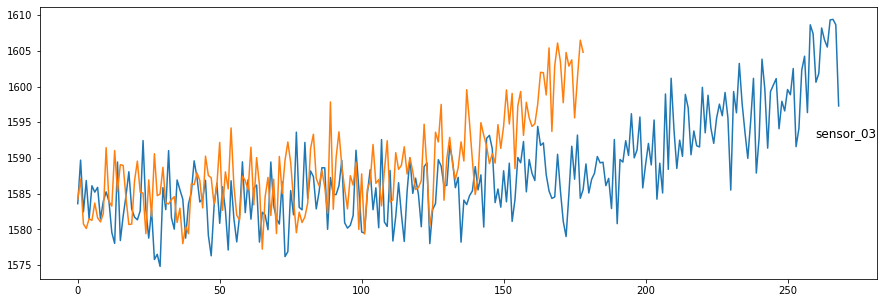

In [14]:
# Comparing the different engines under the same sensor by selecting randomly for intuition

values=[]
groups = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

unit1 = randint(1, 100)
unit2 = randint(1, 100)
values1 = df[df.unit_nr == unit1].values
values2 = df[df.unit_nr == unit2].values
b = randint(0, len(groups)-1) 
a = groups[b]
print("Comparing engine{0:3d} and {1:3d} under the same sensor:".format(unit1, unit2))
plt.figure(figsize=(15,5))
plt.plot(values1[:, a])
plt.title(df.columns[a], y = 0.5, loc = 'right')
plt.plot(values2[:, a])
plt.title(df.columns[a], y = 0.5, loc = 'right')
plt.show()    

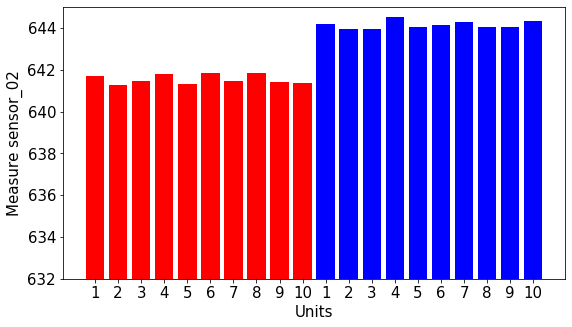

In [15]:
# Viewing max and min values of sensor_02

minb = df.groupby('unit_nr', as_index = False).min().head(10)
maxb = df.groupby('unit_nr', as_index = False).max().head(10)

table = minb.append(maxb, ignore_index=True)

fig = plt.figure(figsize = (9,5))

col = np.concatenate((np.repeat('red', 10), np.repeat('blue', 10)), axis = 0)
bar_labels = list(table['unit_nr'])
x_pos = list(range(len(bar_labels)))
bars = plt.bar(x_pos, table['sensor_02'], color = col)
plt.ylim([632, 645])
plt.xlabel('Units', fontsize = 15)
plt.ylabel('Measure sensor_02', fontsize = 15)
plt.xticks(x_pos, bar_labels, fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()


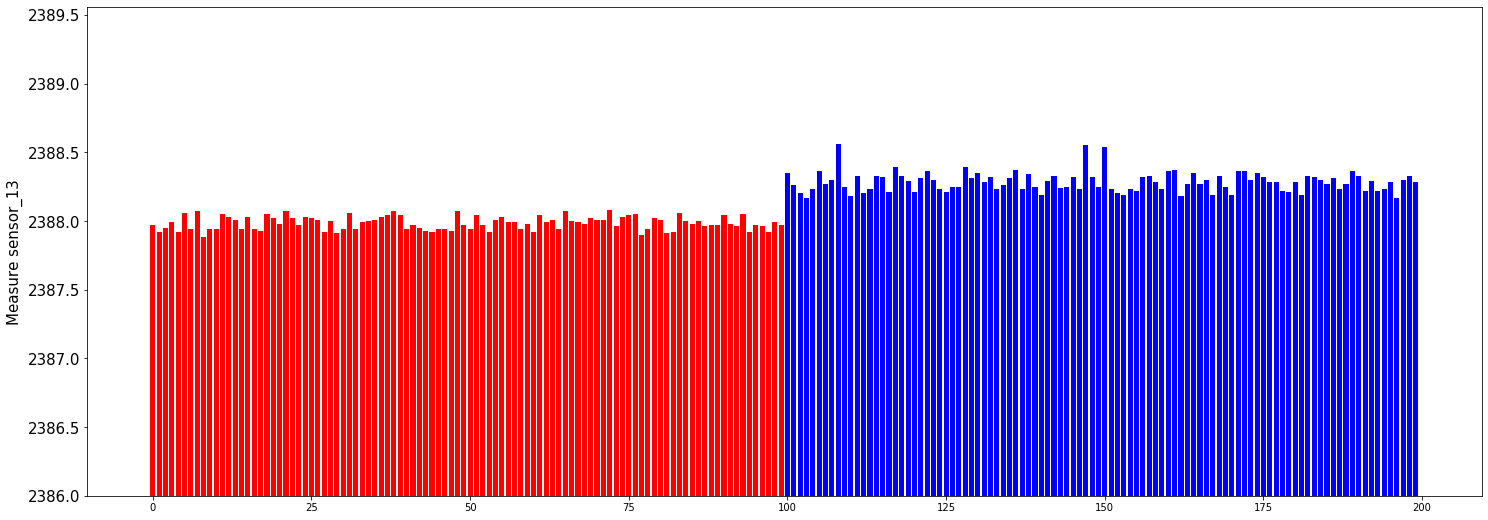

In [16]:
# Viewing max and min values for all engines

minb = df.groupby('unit_nr', as_index = False).min().head(100)
maxb = df.groupby('unit_nr', as_index = False).max().head(100)

table = minb.append(maxb, ignore_index=True)

fig = plt.figure(figsize = (25,9))

col = np.concatenate((np.repeat('red', 100), np.repeat('blue', 100)), axis = 0)
bar_labels = list(table['unit_nr'])
x_pos = list(range(len(bar_labels)))
bars = plt.bar(x_pos, table['sensor_13'], color = col)
plt.ylim([2386, 2389.56])
plt.ylabel('Measure sensor_13', fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [17]:
# Creating new column for RUL time in training data

mapper = {}
for unit_nr in df['unit_nr'].unique():
    mapper[unit_nr] = df['time'].loc[df['unit_nr'] == unit_nr].max()
    
df['RUL'] = df['unit_nr'].apply(lambda nr: mapper[nr]) - df['time']


mapper2 = {}
for unit_nr in df_val['unit_nr'].unique():
    mapper[unit_nr] = df_val['time'].loc[df_val['unit_nr'] == unit_nr].max()
    
df_val['RUL'] = df_val['unit_nr'].apply(lambda nr: mapper[nr]) - df_val['time']

In [18]:
df['RUL'].describe()

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

Text(0.5, 0, 'RUL')

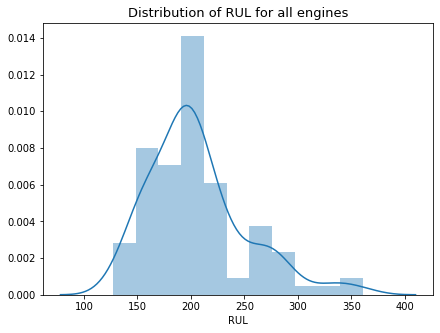

In [19]:
# Distribution of RUL for all engines

RUL_values = list(df.groupby('unit_nr')['RUL'].max())
fig = plt.figure(figsize = (7,5))
ax = sns.distplot(RUL_values)
ax.set_title('Distribution of RUL for all engines', {'fontsize':13});
ax.set_xlabel('RUL')

### Rolling analysis

- A rolling analysis of a time series model is often used for assessing the model’s stability over time. 

- If the parameters change at some point during the observation, and then the rolling estimates should capture this instability.

- We can use moving average smoothing for each observation by using rolling function.

In [20]:
# Rolling sensor values with previous 10 samples by their mean for a smooth flow to the future estimations

def rolling_mean_by_unit(df, n, verbose = False):
    cols_sensors = [c for c in df.columns if c.startswith('sensor')]
    df_new = df.copy()
    unit_nrs = df['unit_nr'].unique()
    
    for nr in unit_nrs:
        if verbose:
            print('processing unit nr: {}'.format(nr))
        idx = df['unit_nr'] == nr
        df_new.loc[idx, cols_sensors] = df.loc[idx, cols_sensors].rolling(n, min_periods = 1).mean()
    return df_new

df_old = df.copy()
rdf = rolling_mean_by_unit(df, 5)
rdf_val = rolling_mean_by_unit(df_val, 5)

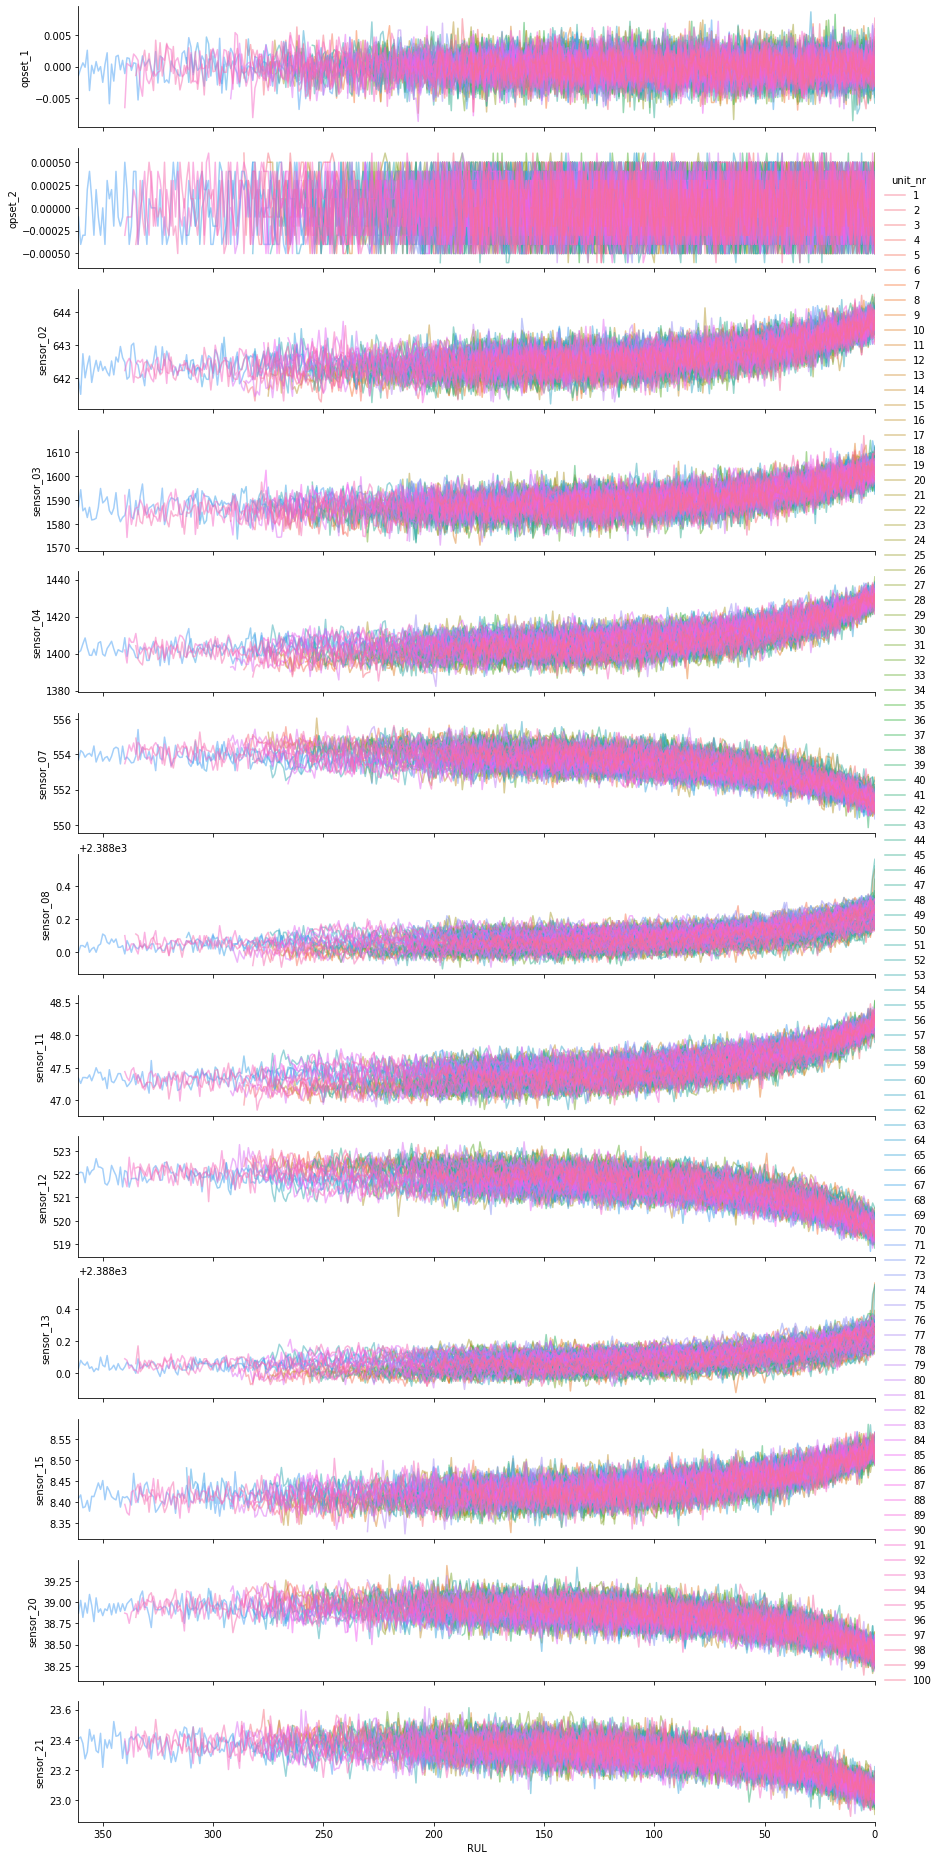

In [21]:
# Ploting the features before rolling by unit and RUL

def plot_grouped_by_RUL(df_sub, leg=True, cols_data=None):

    if cols_data is None: 
        cols = [col for col in df_sub.columns if len(df_sub[col].unique()) > 2]
        cols_data = [col for col in cols if col.startswith('sen') or col.startswith('op')]

    g = sns.PairGrid(data=df_sub, x_vars="RUL", y_vars=cols_data,hue="unit_nr", height=2, aspect=6,)
    g = g.map(plt.plot, alpha=0.5)
    g = g.set(xlim=(df_sub['RUL'].max(),df_sub['RUL'].min()))
    if leg:
        g = g.add_legend()

cols = [c for c in df.columns if c.startswith('s') or c.startswith('o') or c in ['RUL', 'unit_nr']]
plot_grouped_by_RUL(df_old[cols].copy())

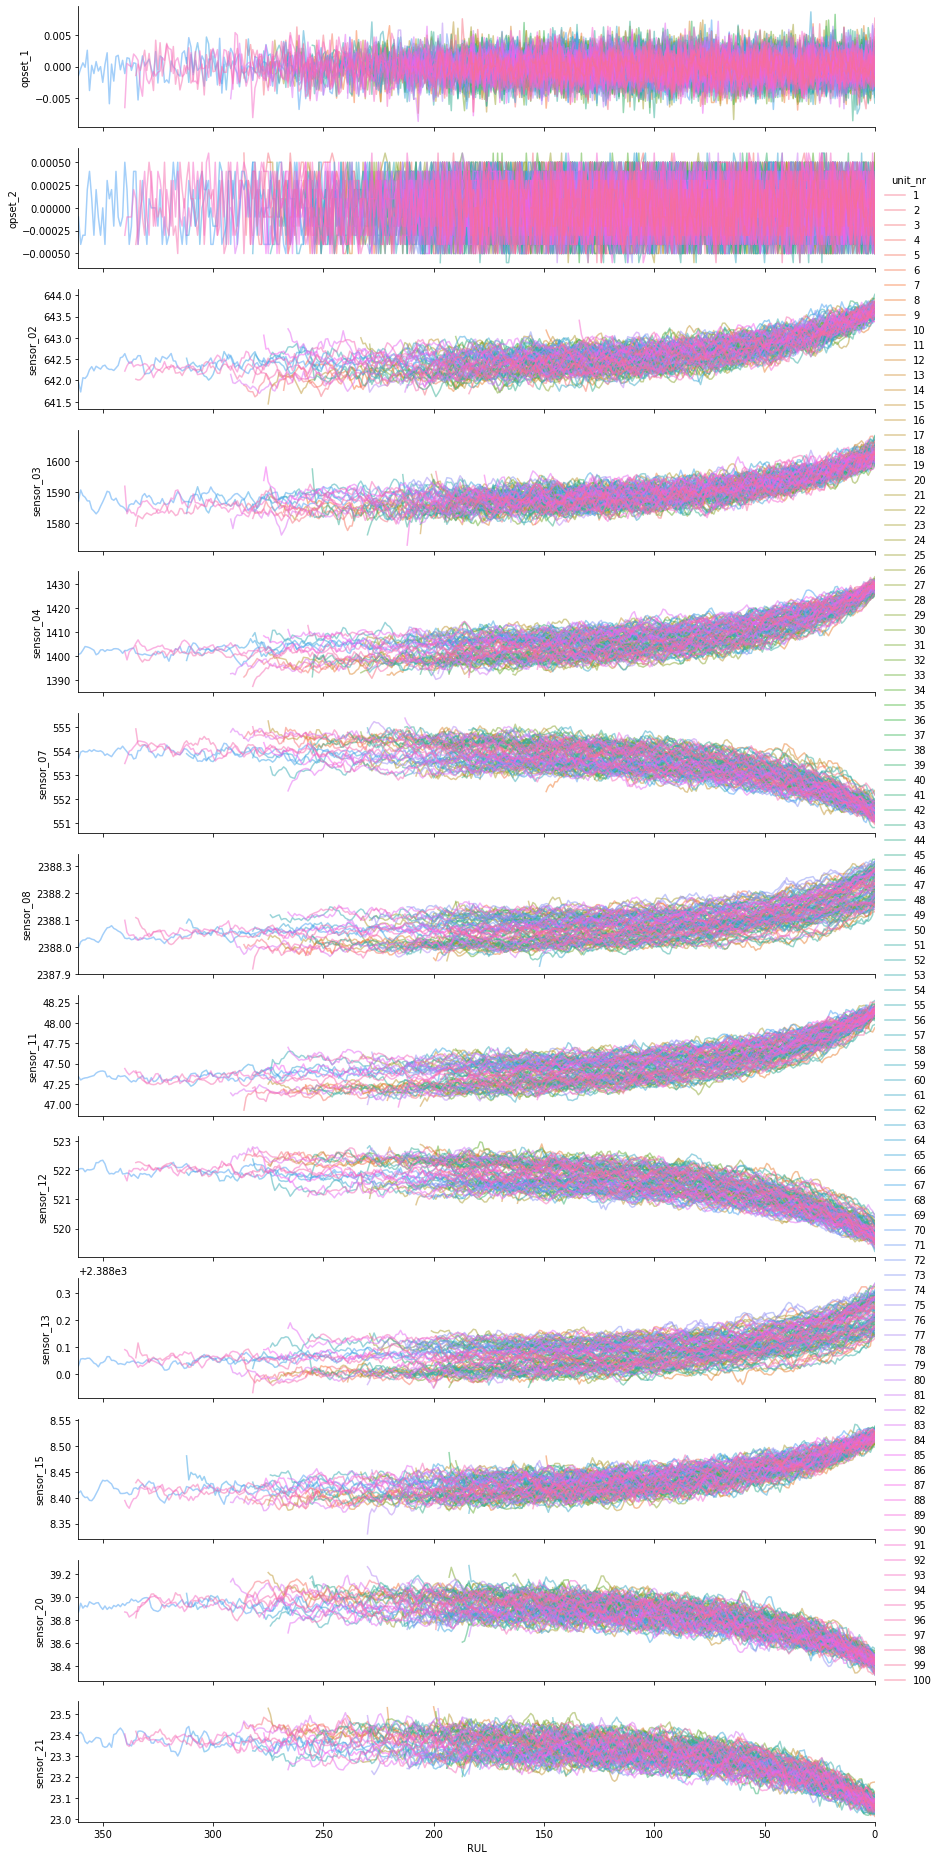

In [22]:
# Ploting the features after rolling by unit and RUL

cols = [c for c in rdf.columns if c.startswith('s') or c.startswith('o') or c in ['RUL', 'unit_nr']]
plot_grouped_by_RUL(rdf[cols].copy())

In [23]:
# Excluding operational setting columns which have inconsistent values from the dataset

df.drop(['opset_1', 'opset_2'], axis = 1, inplace = True)
rdf.drop(['opset_1', 'opset_2'], axis = 1, inplace = True)
rdf_val.drop(['opset_1', 'opset_2'], axis = 1, inplace = True)

### Standardize features by removing the mean and scaling to unit variance

In [24]:
scl = StandardScaler()
rdf = scl.fit_transform(rdf.iloc[:,2:13])
rdf_val = scl.transform(rdf_val.iloc[:,2:13])

- Upper threshold and lower threshold values need to be defined for health index. 
- Health index in 0 and 1.
- if one engine with certain e and f pairing violates either one of operational margins under any possible operational conditions, such as hot day take off, maximum climb, or cruise, its health index would be zero. 
- Health index starts at 1.00 and ends at 0.00. In the data set each degradation trajectory was simulated until the health index reached zero. 

In [25]:
rdf = pd.concat([df.loc[:,'unit_nr':'time'], pd.DataFrame(rdf, columns=['sensor_02', 'sensor_03', 'sensor_04', 'sensor_07', 'sensor_08',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15', 'sensor_20','sensor_21'])], axis=1)
rdf_val = pd.concat([df_val.loc[:,'unit_nr':'time'], pd.DataFrame(rdf_val, columns=['sensor_02', 'sensor_03', 'sensor_04', 'sensor_07', 'sensor_08',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15', 'sensor_20','sensor_21'])], axis=1)

In [26]:
rdf = pd.concat([rdf, df.loc[:,'RUL']], axis=1)

In [27]:
rdf.head()

unit_nr  time  sensor_02  sensor_03  sensor_04  sensor_07  sensor_08  \
0        1     1  -2.067769  -0.138150  -1.004816   1.228170  -0.544814   
1        1     2  -1.665516   0.079774  -0.846703   0.840998  -0.700981   
2        1     3  -1.368905  -0.110053  -0.750009   0.927742  -0.544814   
3        1     4  -1.220599  -0.472231  -0.774183   1.031411  -0.349605   
4        1     5  -1.121865  -0.687070  -0.680373   0.979365  -0.388647   

   sensor_11  sensor_12  sensor_13  sensor_15  sensor_20  sensor_21  RUL  
0  -0.258466   0.337071  -1.145405  -0.674506   1.564172   1.379118  191  
1  -0.217596   0.800321  -0.760235  -0.482748   1.367661   1.404213  190  
2  -0.503688   1.024475  -0.837269  -0.564336   1.192984   1.123794  189  
3  -0.789780   1.300930  -0.683201  -0.991766   0.991014   1.064600  188  
4  -0.838824   1.266560  -0.714015  -0.866577   0.896034   1.095643  187

In [28]:
# Creating Model
# A. Arrhenius
# B. Coffin-Mason Mechanical Crack Growth Model
# C. Eyring Model
# D. Damage Propagation Model for the Challenge Problem

We used a kind of physics-inspired data-generation approach like A., B., C.  

We assume a generalized equation for wear:

# $w=Ae^{B(t)}$

## $h(t)=1-Ae^{B(t)/th_w}$

where $th_w$ is an upper wear threshold. Recasting parameter  $A/t_{hw} = e^a$ and expressing $B(t)=t^b$, the health equation becomes

## $h(t)=1-exp\{at^b\}$

## $h(t)=1-d-exp\{at^b\}$ 
where d is allowing the data-generation process to start at an arbitrary point in the wear-space.

The health equation can also described both by efficiency ($e$) and flow ($f$) in the for aircraft
engine modules like the compressor section.

## $e(t)=1-d_e-exp\{a_e(t)t^{b_e(t)}\}$ 
## $f(t)=1-d_f-exp\{a_f(t)t^{b_f(t)}\}$ 
The terms e(t) and f(t) are then aggregated to form the overall health index H(t):

$H(t)=g(e(t),f(t))$

where, the function g is the minimum of all operative margins considered.

In [29]:
def healthindex(data, k):
    return(data.RUL[k] - data.RUL.min()) / float(data.RUL.max() - data.RUL.min())

In [30]:
HI_ = []
HI  = []

for i in range(df['unit_nr'].min(), df['unit_nr'].max() + 1):
    data = df[df.unit_nr == i]
    data = data.reset_index(drop = True)
    for k in range(len(data)):
        HI_ = healthindex(data, k)
        HI.append(HI_)
        
rdf['HI'] = HI

In [31]:
rdf.head()

unit_nr  time  sensor_02  sensor_03  sensor_04  sensor_07  sensor_08  \
0        1     1  -2.067769  -0.138150  -1.004816   1.228170  -0.544814   
1        1     2  -1.665516   0.079774  -0.846703   0.840998  -0.700981   
2        1     3  -1.368905  -0.110053  -0.750009   0.927742  -0.544814   
3        1     4  -1.220599  -0.472231  -0.774183   1.031411  -0.349605   
4        1     5  -1.121865  -0.687070  -0.680373   0.979365  -0.388647   

   sensor_11  sensor_12  sensor_13  sensor_15  sensor_20  sensor_21  RUL  \
0  -0.258466   0.337071  -1.145405  -0.674506   1.564172   1.379118  191   
1  -0.217596   0.800321  -0.760235  -0.482748   1.367661   1.404213  190   
2  -0.503688   1.024475  -0.837269  -0.564336   1.192984   1.123794  189   
3  -0.789780   1.300930  -0.683201  -0.991766   0.991014   1.064600  188   
4  -0.838824   1.266560  -0.714015  -0.866577   0.896034   1.095643  187   

         HI  
0  1.000000  
1  0.994764  
2  0.989529  
3  0.984293  
4  0.979058

In [32]:
#linear regression 
m = ols('HI ~ sensor_02+sensor_03+sensor_04+sensor_07+sensor_08+sensor_11+sensor_12+sensor_13+sensor_15+sensor_20+sensor_21', rdf).fit()
print (m.summary())

                            OLS Regression Results                            
Dep. Variable:                     HI   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3653.
Date:                Tue, 28 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:05:50   Log-Likelihood:                 7413.7
No. Observations:               20631   AIC:                        -1.480e+04
Df Residuals:                   20619   BIC:                        -1.471e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5000      0.001    425.013      0.0

In [33]:
# Fitting the Linear Regression Model obtained from training data on the test set.

rdf_val['HI'] = m.predict(rdf_val)
rdf_val.head()

unit_nr  time  sensor_02  sensor_03  sensor_04  sensor_07  sensor_08  \
0        1     1   0.857709  -1.044794  -1.302368   0.644239  -0.857148   
1        1     2  -0.739114  -0.719964  -1.476043   1.247212  -1.091398   
2        1     3  -0.661914  -0.715167  -1.288258   1.135080  -0.961259   
3        1     4  -0.635504  -0.857708  -1.036252   1.066320  -0.974273   
4        1     5  -0.585527  -0.817002  -0.997097   1.047913  -1.044548   

   sensor_11  sensor_12  sensor_13  sensor_15  sensor_20  sensor_21        HI  
0  -1.361964   0.426733  -0.991337  -1.120384   0.254097   0.882655  0.676991  
1  -0.748910   0.755491  -0.760235  -1.508579   0.778127   0.981402  0.730844  
2  -0.544558   0.770434  -0.837269  -0.974876   1.083811   1.105245  0.708305  
3  -0.667169   0.557489  -0.798752  -1.116487   1.105646   1.050143  0.696206  
4  -0.716213   0.659852  -0.837269  -1.130362   1.105646   1.102844  0.693491

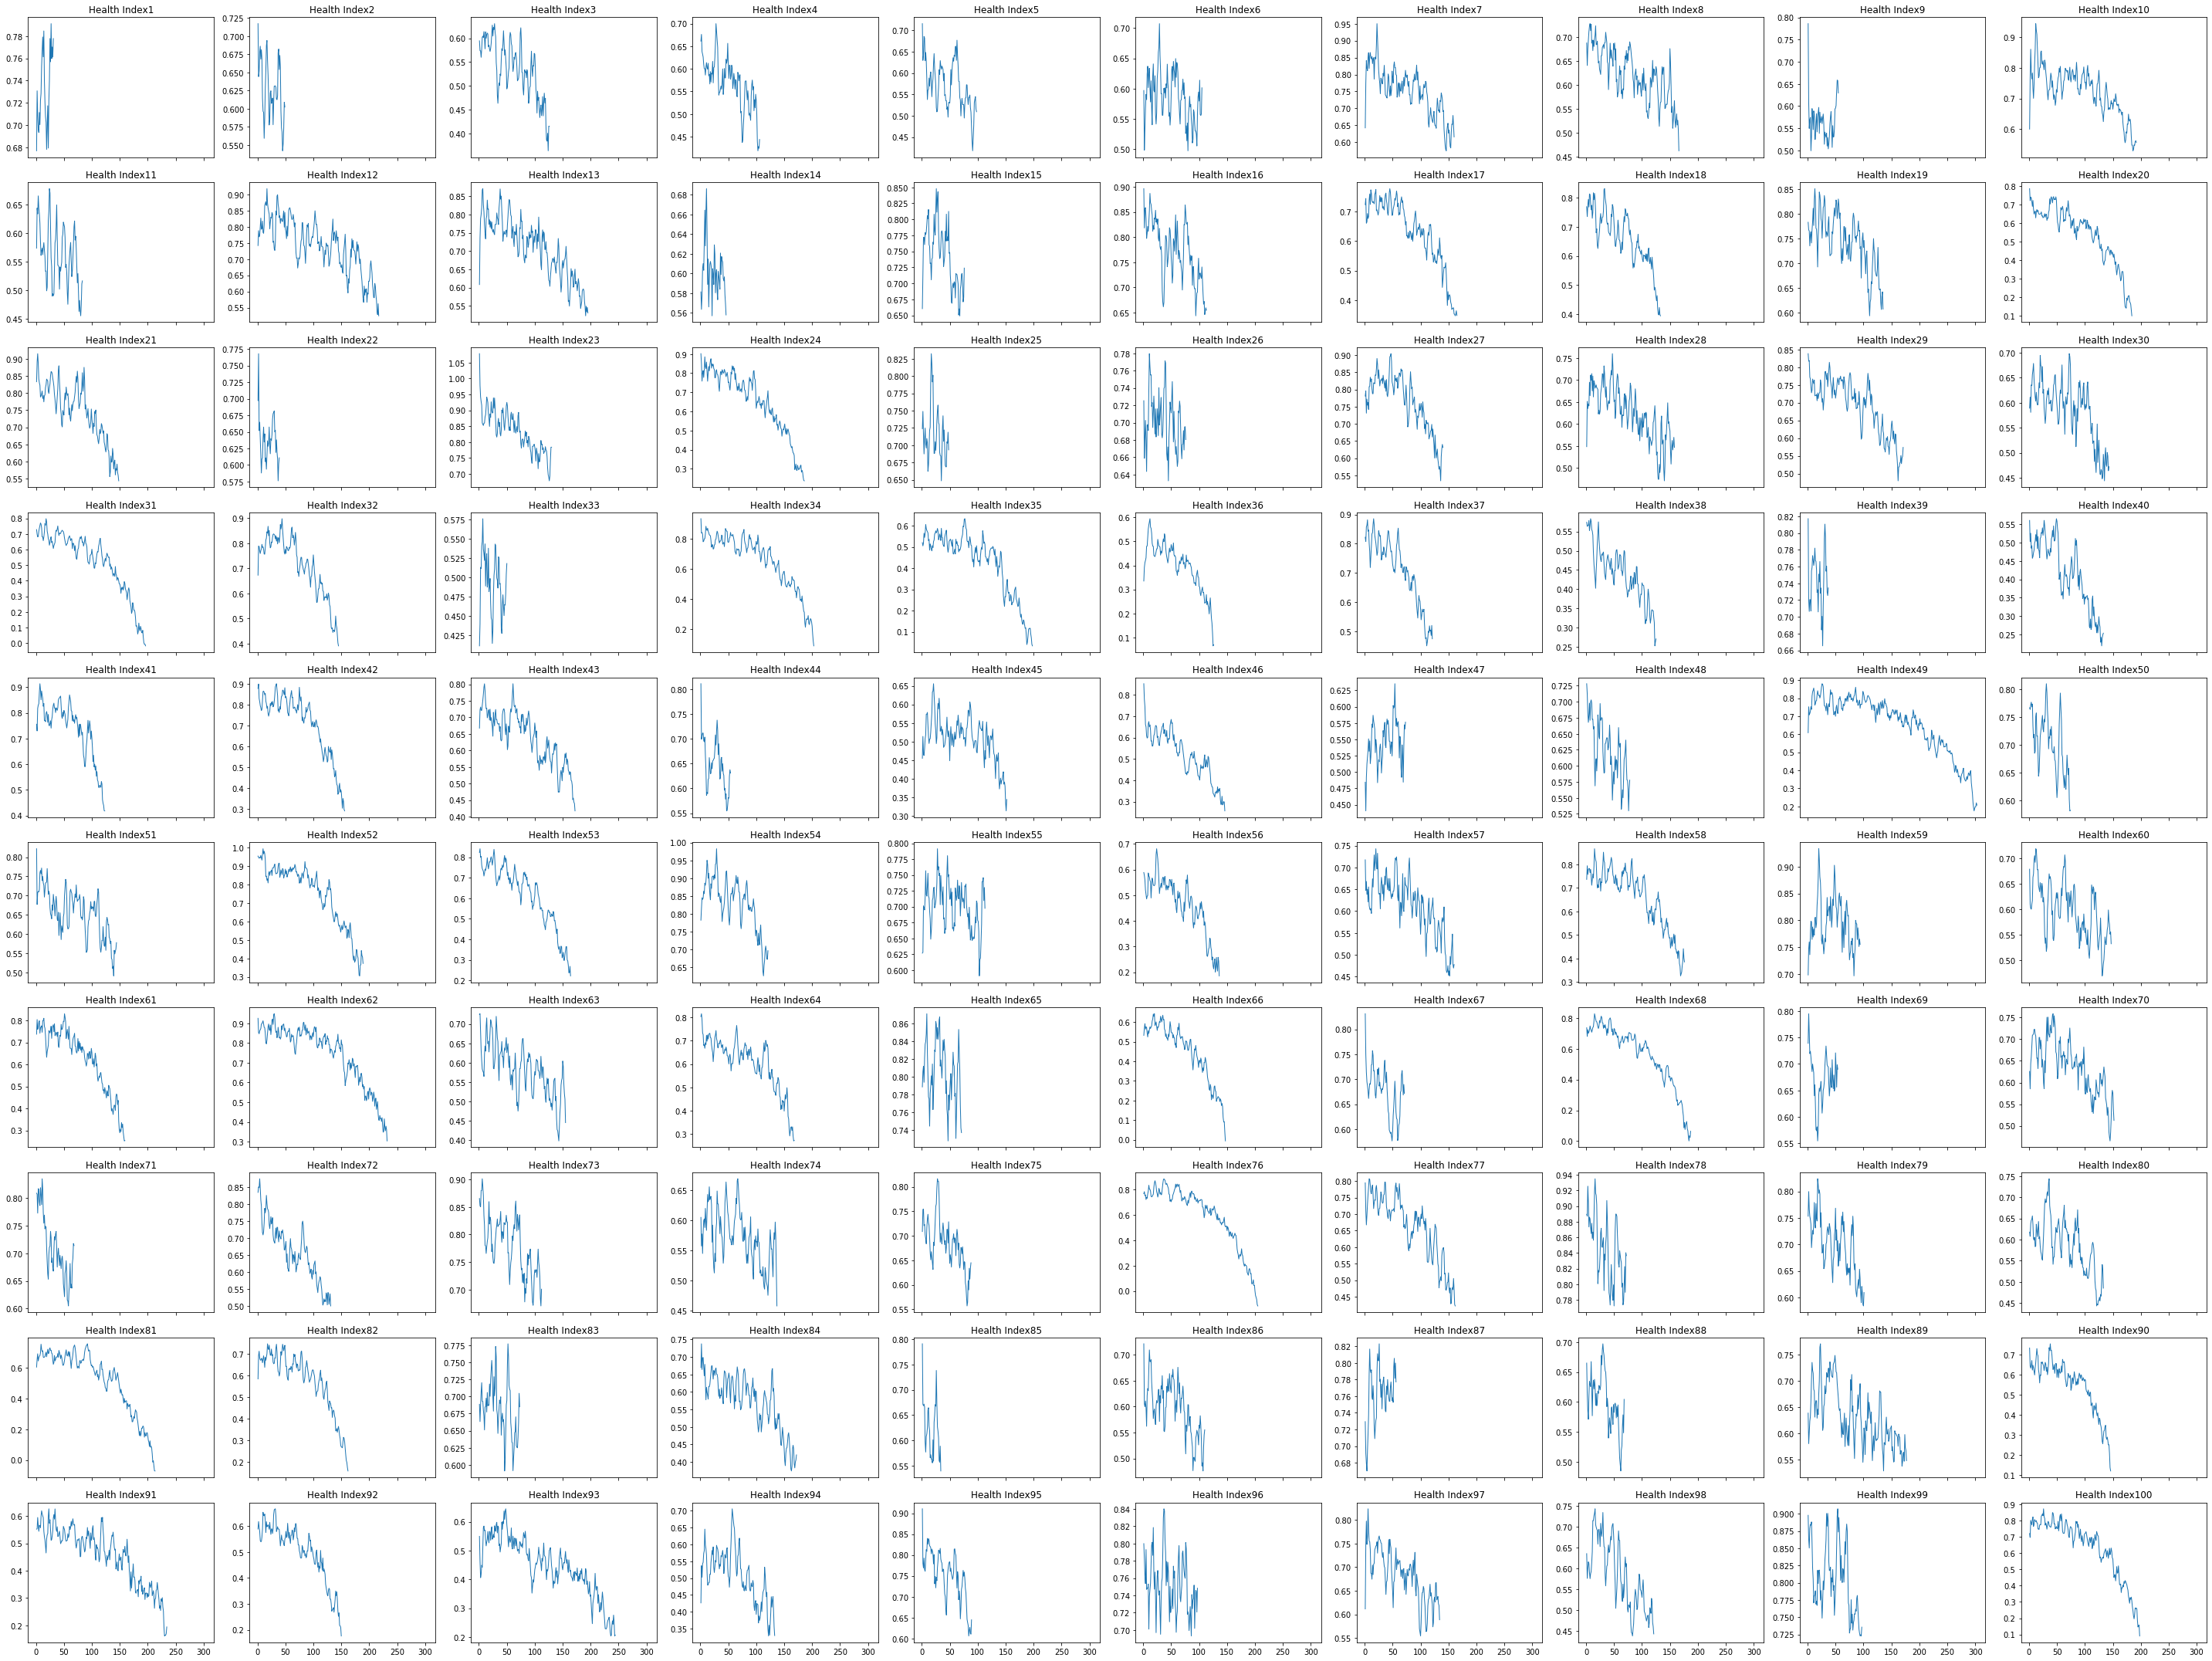

In [34]:
# Plotting health indexes of the test data for each engine

fig, ax = plt.subplots(10, 10, figsize = (40, 30), sharex = True)
c = 1

for i in range(0, 10):
    for j in range(0, 10):
        df_ = rdf_val.query('unit_nr==' + str(c))
        ax[i,j].plot(df_['time'], df_.HI.values,linewidth = 1)
        ax[i,j].set_title('Health Index' + str(c))
        c += 1

plt.tight_layout()
plt.show()

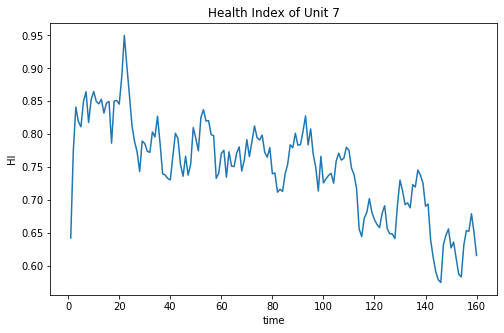

In [35]:
# Plotting health index of engine 7 
fig, ax = plt.subplots(1, 1, figsize = (8,5), sharex = True)
df_ = rdf_val.query('unit_nr==7')
ax.plot(df_['time'], df_.HI.values )
ax.set_title('Health Index of Unit 7')
ax.set(xlabel = 'time', ylabel = 'HI')
plt.show()

### Smoothing the function of health index

In [36]:
# Defining a function for smoothing of health index

def hi_avg(df, un):
    temp_df = df.query('unit_nr=='+str(un))
    rolling = temp_df['HI'].rolling(window = 5)
    rolling_mean = rolling.mean()
    return rolling_mean

all_rolling_means = [hi_avg(rdf_val, i) for i in range(1,101)]
rdf_val = rdf_val.assign(MA_HI = list(itertools.chain.from_iterable(all_rolling_means)))
rdf_val.dropna(inplace=True)
rdf_val.head()

unit_nr  time  sensor_02  sensor_03  sensor_04  sensor_07  sensor_08  \
4        1     5  -0.585527  -0.817002  -0.997097   1.047913  -1.044548   
5        1     6  -1.029224  -1.070698  -1.073788   1.129156  -1.169482   
6        1     7  -0.834193  -1.280809  -0.839233   0.885428  -1.044548   
7        1     8  -0.795186  -1.529571  -0.850438   0.753409  -1.044548   
8        1     9  -1.068231  -1.152522  -0.704526   0.860040  -0.950848   

   sensor_11  sensor_12  sensor_13  sensor_15  sensor_20  sensor_21        HI  \
4  -0.716213   0.659852  -0.837269  -1.130362   1.105646   1.102844  0.693491   
5  -0.667169   0.719626  -0.683201  -1.014371   1.171150   1.044360  0.711413   
6  -0.822476   0.674796  -0.683201  -0.945151   0.948437   1.052216  0.700410   
7  -1.059524   0.710660  -0.590761  -1.087333   0.909135   0.846648  0.722235   
8  -0.985957   0.904926  -0.590761  -0.815441   1.040142   1.017737  0.728479   

      MA_HI  
4  0.701168  
5  0.708052  
6  0.701965  
7  0.704751  
8  0.711206

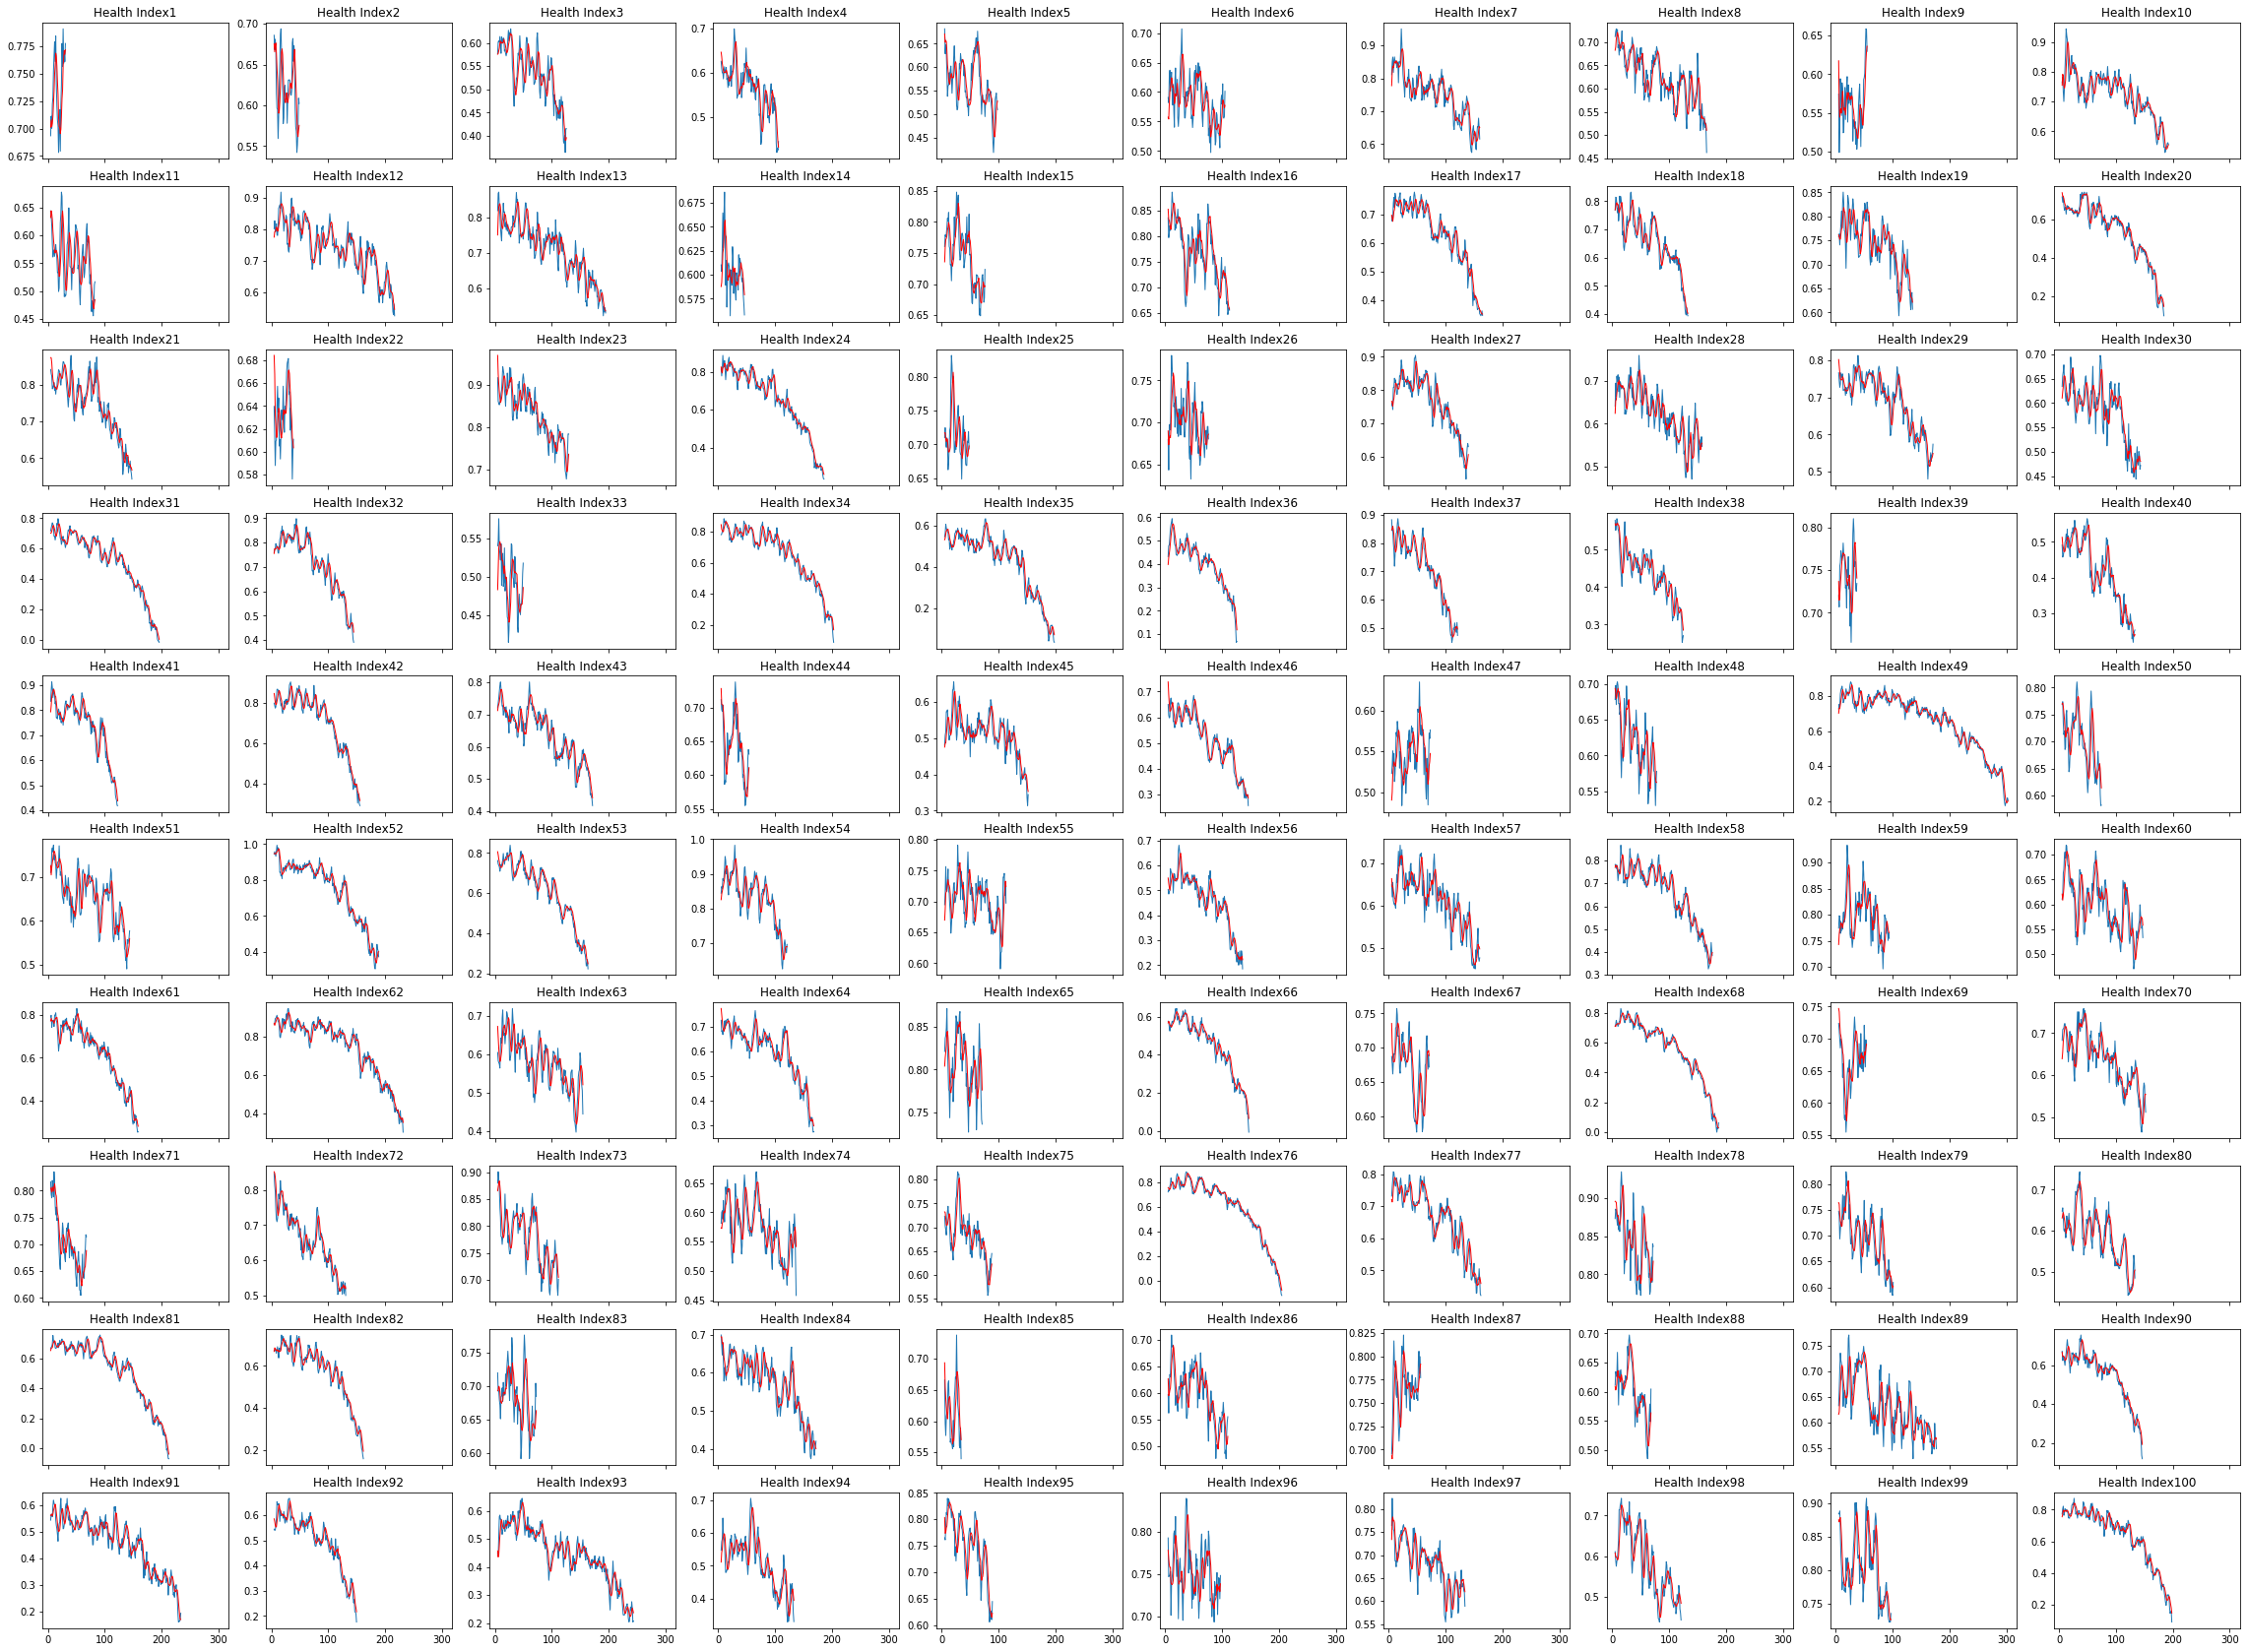

In [37]:
# Plotting health index after smoothing

fig,ax = plt.subplots(10, 10, figsize = (40,30), sharex = True)
c=1
for i in range(0,10):
    for j in range(0,10):
        df_ = rdf_val.query('unit_nr=='+str(c))
        ax[i,j].plot(df_['time'], df_.HI.values, linewidth = 1)
        ax[i,j].plot(df_['time'], df_.MA_HI.values, linewidth = 1, color = 'r')
        ax[i,j].set_title('Health Index'+str(c))
        c+=1

Text(0.5, 1.0, 'Health Index')

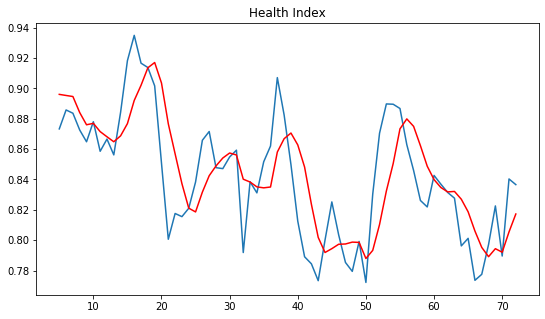

In [38]:
# Plotting health index for exact engine

fig, ax = plt.subplots(1, 1, figsize = (9,5),sharex = True)
df_ = rdf_val.query('unit_nr==78')
ax.plot(df_['time'],df_.HI.values)
ax.plot(df_['time'],df_.MA_HI.values, color = 'r')
ax.set_title('Health Index')

### RUL Estimation

In [39]:
# Defining cost function

def scoring_function(error):
    if error>=0:
        s=np.exp(error/10)-1
        return s
    else:
        s=np.exp(-error/13)-1
        return s

In [40]:
#Converting the RUL_1's RUL column to a list

RUL = list(RUL_1['RUL'].values)

In [41]:
#Fitting the Polynomial to every engine

degrees    = range(6)
degree_fit = []
final_score=[]
estimated_rul_dict={}
roots_dict={}

for i in range(1,101):
    
    #Creating a sub-dataframe for every engine
    uniti = rdf_val.query('unit_nr=='+str(i))
    
    score      = np.empty(len(degrees))
    
    estimated_rul_dict['unit_nr'+str(i)] = {}
    roots_dict['unit_nr'+str(i)] = {}
    
    for d in degrees:
        
        poly_params = np.polyfit(uniti['time'],uniti['MA_HI'],d)       #Fit data to the polynomial
        poly_       = np.poly1d(poly_params)                            #Construct the polynomial
        
        roots = poly_.r                                                 #Calculating roots of the polynomial
        roots = roots[np.isreal(roots)].real                            #Filtering out the real roots
        roots = roots[roots>0]                                          #Filtering out the positive roots
        
        if roots.shape[0]==1:
            pred_rul = roots - max(uniti['time'])                      #Calculating the remaining useful life
        
            errors = pred_rul - RUL[i-1] 
        
            score[d]=scoring_function(errors)
            
            estimated_rul_dict['unit_nr'+str(i)][scoring_function(errors).item()] = pred_rul.item()
            
            roots_dict['unit_nr'+str(i)][scoring_function(errors).item()] = roots.item()            
            
        elif roots.shape[0]>1:
            pred_rul = roots[0] - max(uniti['time'])
            
            errors = pred_rul - RUL[i-1]
            
            score[d]=scoring_function(errors)
            
            estimated_rul_dict['unit_nr'+str(i)][scoring_function(errors).item()] = pred_rul.item()
       
            roots_dict['unit_nr'+str(i)][scoring_function(errors).item()] = roots[0].item()
        
        else:
            score[d]=scoring_function(7000)
        
    
    degree_fit.append(np.argmin(score))
    final_score.append(np.min(score))

In [42]:
predicted_ruls = []
for i in estimated_rul_dict.keys():
    predicted_ruls.append(estimated_rul_dict[i][min(estimated_rul_dict[i].keys())])
    
roots_list=[]
for i in roots_dict.keys():
    roots_list.append(roots_dict[i][min(roots_dict[i].keys())])

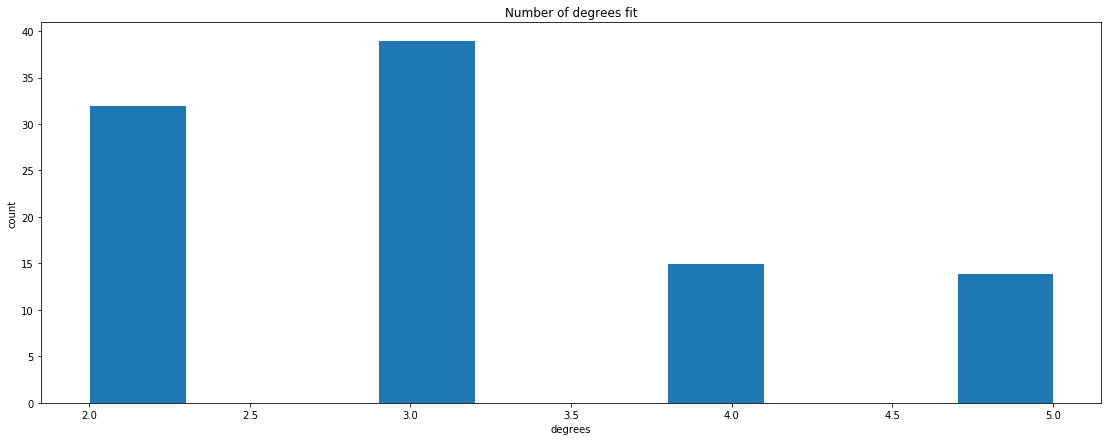

In [43]:
fig,ax=plt.subplots(1, 1, figsize = (19, 7))

ax.hist(degree_fit,edgecolor='white')
ax.set(xlabel='degrees',ylabel='count',title='Number of degrees fit')

plt.show()

In [44]:
#Creating a metric dataframe having engine number, the degree to which it was fit and its score

metric_poly = pd.DataFrame({'unit_nr':list(range(1,101)),'Degree':degree_fit,
                     'Score':final_score,'Predicted_RUL':predicted_ruls,'Actual_RUL':RUL,
                     'Polynomial_root':roots_list},
                    columns=['unit_nr','Degree','Score','Predicted_RUL','Actual_RUL',
                            'Polynomial_root'])
metric_poly

unit_nr  Degree         Score  Predicted_RUL  Actual_RUL  Polynomial_root
0         1       5  3.594676e+03       5.562664         112        36.562664
1         2       3  3.666456e+02      21.207448          98        70.207448
2         3       3  5.972034e+00      43.755208          69       169.755208
3         4       3  3.988932e+01     119.108689          82       225.108689
4         5       2  2.324819e+01     122.883418          91       220.883418
5         6       2  1.761828e+02     144.771822          93       249.771822
6         7       3  1.465923e+00      79.266641          91       239.266641
7         8       3  7.552171e+00     116.461851          95       282.461851
8         9       5  6.856124e+02      26.086990         111        81.086990
9        10       3  7.250081e+00      68.567100          96       260.567100
10       11       3  1.568322e+02      31.200075          97       114.200075
11       12       3  5.276469e-01     118.491528         124       335.491528
12       13       4  7.686935e-01      87.586865          95       282.586865
13       14       4  1.340624e+03      13.378734         107        59.378734
14       15       2  7.843817e-01      88.790720          83       164.790720
15       16       3  1.427112e+01      48.562478          84       161.562478
16       17       3  6.920756e-01      43.162573          50       208.162573
17       18       4  2.529375e-01      25.068619          28       158.068619
18       19       4  1.462132e+00      75.286638          87       210.286638
19       20       3  2.177075e-04      16.002177          16       200.002177
20       21       3  1.485190e-01      55.199847          57       203.199847
21       22       3  1.470558e+03      16.176996         111        55.176996
22       23       5  3.663154e+02      36.219127         113       166.219127
23       24       4  3.141029e-01      22.731542          20       208.731542
24       25       2  5.341239e+02      63.327521         145       111.327521
25       26       2  1.353601e+02     168.152995         119       244.152995
26       27       2  2.298255e+00      77.933935          66       217.933935
27       28       2  4.611475e+05     227.414754          97       385.414754
28       29       3  2.652933e+00     102.955305          90       273.955305
29       30       2  1.430951e+00     103.452327         115       246.452327
..      ...     ...           ...            ...         ...              ...
70       71       3  8.816230e+00      88.307517         118       156.307517
71       72       3  2.519776e-01      47.078583          50       178.078583
72       73       5  6.882475e-01     124.192017         131       236.192017
73       74       2  1.365815e+03     198.202382         126       335.202382
74       75       2  6.167340e+00      87.396050         113       175.396050
75       76       2  7.830379e-01       2.481858          10       207.481858
76       77       4  1.442989e+00      42.932224          34       204.932224
77       78       3  1.214159e-01     105.510303         107       177.510303
78       79       3  9.589128e-01      54.258935          63       155.258935
79       80       4  1.721765e-01      87.934791          90       220.934791
80       81       2  2.395091e-01       5.208700           8       218.208700
81       82       4  5.341985e-01      13.280081           9       175.280081
82       83       2  8.830455e+00     107.288693         137       180.288693
83       84       3  5.510331e-01      52.294024          58       224.294024
84       85       3  3.068650e+03      13.618855         118        47.618855
85       86       3  9.739833e-01      80.159305          89       190.159305
86       87       2  1.570755e+00     125.441995         116       181.441995
87       88       2  7.498732e+01      58.702636         115       126.702636
88       89       4  6.945850e+02      50.918208         136       227.918208
89       90       2  1.714

In [53]:
metric_poly[metric_poly.Predicted_RUL<=30]

unit_nr  Degree         Score  Predicted_RUL  Actual_RUL  Polynomial_root
0         1       5   3594.676310       5.562664         112        36.562664
1         2       3    366.645579      21.207448          98        70.207448
8         9       5    685.612426      26.086990         111        81.086990
13       14       4   1340.623611      13.378734         107        59.378734
17       18       4      0.252938      25.068619          28       158.068619
19       20       3      0.000218      16.002177          16       200.002177
21       22       3   1470.558342      16.176996         111        55.176996
23       24       4      0.314103      22.731542          20       208.731542
30       31       2      0.037669       8.369768           8       204.369768
33       34       5      0.904855      13.444061           7       216.444061
34       35       2      0.051935      11.506310          11       209.506310
35       36       3      0.085237      19.817980          19       145.817980
38       39       4  10211.586249      21.992110         142        58.992110
39       40       4      0.769525      20.580757          28       153.580757
40       41       5      0.222601      15.387250          18       138.387250
41       42       5      2.244737      21.770342          10       177.770342
42       43       5     10.808875      26.904933          59       198.904933
48       49       5      0.289234      23.540480          21       326.540480
51       52       3      0.032830      29.323027          29       218.323027
52       53       3      0.032428      26.319134          26       190.319134
55       56       4      0.441895      10.242540          15       146.242540
60       61       5      0.104487      19.708053          21       178.708053
63       64       3      0.261691      24.978117          28       192.978117
64       65       5   3450.926644      22.093059         128        93.093059
65       66       3      0.109887      15.042578          14       162.042578
67       68       3      0.259666       4.998997           8       191.998997
68       69       3   1986.133056      22.272173         121        76.272173
75       76       2      0.783038       2.481858          10       207.481858
80       81       2      0.239509       5.208700           8       218.208700
81       82       4      0.534198      13.280081           9       175.280081
84       85       3   3068.649997      13.618855         118        47.618855
89       90       2      0.171492      29.582780          28       175.582780
91       92       4      0.013735      19.822665          20       169.822665
99      100       3      0.275256      16.839093          20       214.839093

In [54]:
metric_poly[metric_poly.Actual_RUL<=30]

unit_nr  Degree     Score  Predicted_RUL  Actual_RUL  Polynomial_root
17       18       4  0.252938      25.068619          28       158.068619
19       20       3  0.000218      16.002177          16       200.002177
23       24       4  0.314103      22.731542          20       208.731542
30       31       2  0.037669       8.369768           8       204.369768
33       34       5  0.904855      13.444061           7       216.444061
34       35       2  0.051935      11.506310          11       209.506310
35       36       3  0.085237      19.817980          19       145.817980
36       37       3  6.941001      41.720393          21       162.720393
39       40       4  0.769525      20.580757          28       153.580757
40       41       5  0.222601      15.387250          18       138.387250
41       42       5  2.244737      21.770342          10       177.770342
48       49       5  0.289234      23.540480          21       326.540480
51       52       3  0.032830      29.323027          29       218.323027
52       53       3  0.032428      26.319134          26       190.319134
55       56       4  0.441895      10.242540          15       146.242540
60       61       5  0.104487      19.708053          21       178.708053
63       64       3  0.261691      24.978117          28       192.978117
65       66       3  0.109887      15.042578          14       162.042578
67       68       3  0.259666       4.998997           8       191.998997
75       76       2  0.783038       2.481858          10       207.481858
80       81       2  0.239509       5.208700           8       218.208700
81       82       4  0.534198      13.280081           9       175.280081
89       90       2  0.171492      29.582780          28       175.582780
91       92       4  0.013735      19.822665          20       169.822665
99      100       3  0.275256      16.839093          20       214.839093

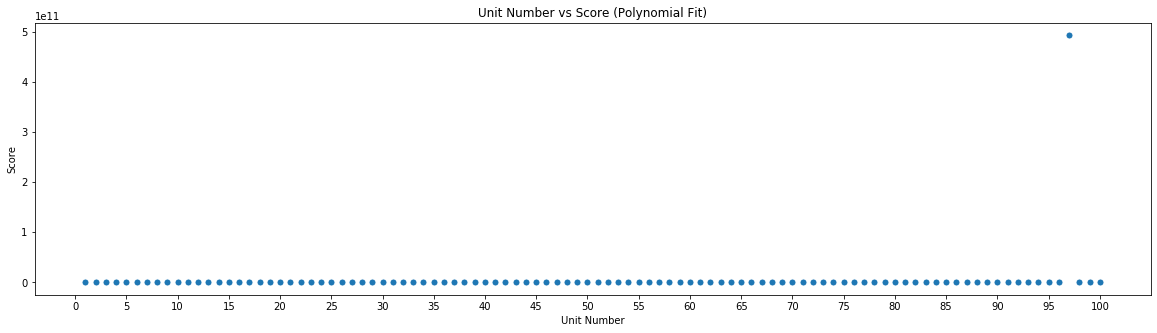

In [45]:
# Plotting score function

fig,ax = plt.subplots(1,1, figsize = (20,5))
ax.scatter(metric_poly.unit_nr, metric_poly.Score, edgecolor='white',  s=50)
ax.set_xticks(np.arange(0,105,5))
ax.set(xlabel='Unit Number',ylabel='Score',title='Unit Number vs Score (Polynomial Fit)')
plt.show()

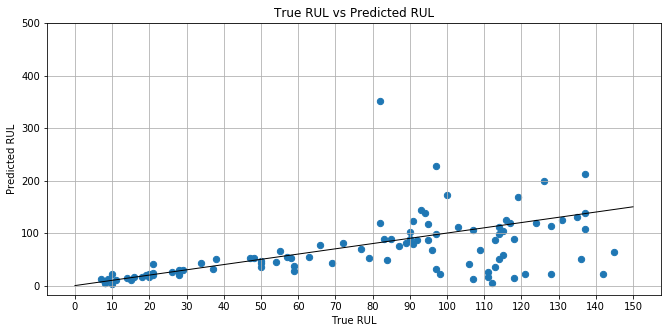

In [46]:
# Plotting actual vs predicted RUL

fig,ax=plt.subplots(1,1,figsize=(11,5))

ax.scatter(metric_poly.Actual_RUL,metric_poly.Predicted_RUL, s=40)
ax.grid()
ax.plot(np.arange(0,160,10),np.arange(0,160,10),c='black',linewidth=1)
ax.set(xlabel='True RUL',ylabel='Predicted RUL',title='True RUL vs Predicted RUL')
ax.set_xticks(np.arange(0,160,10))
ax.set_yticks(np.arange(0,600,100))
plt.show()

RUL is 7
The root at degree 0 is: []
Pred RUL at degree 1 d is: [138.27693312]
Error at degree 1 d is: [131.27693312]
Score at degree 1 d is: [502671.08186046]
The root at degree 1 is: [341.27693312]
Pred RUL at degree 2 d is: [30.00444985]
Error at degree 2 d is: [23.00444985]
Score at degree 2 d is: [8.97862181]
The root at degree 2 is: [233.00444985]
Pred RUL at degree 3 d is: [18.19798425]
Error at degree 3 d is: [11.19798425]
Score at degree 3 d is: [2.06423647]
The root at degree 3 is: [221.19798425]
Pred RUL at degree 4 d is: 535.8811680570743
Error at degree 4 d is: 528.8811680570743
Score at degree 4 d is: 9.311449387004463e+22
The root at degree 4 is: [738.88116806 222.92960428]
Pred RUL at degree 5 d is: [13.44406119]
Error at degree 5 d is: [6.44406119]
Score at degree 5 d is: [0.90485544]
The root at degree 5 is: [216.44406119]


Text(0.5, 1.0, 'Health Index')

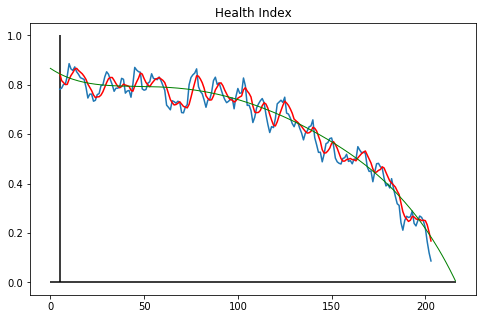

In [47]:
u = 34
unit3=rdf_val.query('unit_nr=='+str(u))
print('RUL is '+ str(RUL[u-1]))
rul_dict={}
for i in range(6):
    poly_params = np.polyfit(unit3['time'], unit3['MA_HI'],i)   #Fit the data to the polynomial
    poly_1_test = np.poly1d(poly_params)                             #Consruct the polynomial

    roots = poly_1_test.r
    roots
    roots = roots[np.isreal(roots)].real
    roots = roots[roots>0]
    
    if roots.shape[0]==1:
            pred_rul = roots - max(unit3['time'])                      #Calculating the remaining useful life
        
            er = pred_rul - RUL[u-1] 
        
            sc = scoring_function(er)
            
            rul_dict[sc.item()] = pred_rul
            print('Pred RUL at degree ' +str(i)+' d is:',pred_rul)
            print('Error at degree ' +str(i)+' d is:',er)
            print('Score at degree '+str(i)+' d is:',sc)
    elif roots.shape[0]>1:
            pred_rul = roots[0] - max(unit3['time'])                      #Calculating the remaining useful life
        
            er = pred_rul - RUL[u-1] 
        
            sc = scoring_function(er)
            
            rul_dict[sc.item()] = pred_rul
            print('Pred RUL at degree ' +str(i)+' d is:',pred_rul)
            print('Error at degree ' +str(i)+' d is:',er)
            print('Score at degree '+str(i)+' d is:',sc)
        
    print('The root at degree '+str(i)+' is:',roots)

fig,ax=plt.subplots(1,1,figsize = (8,5),sharex = True)
ax.plot(unit3['time'], unit3.HI.values)
ax.plot(unit3['time'], unit3.MA_HI.values,color = 'r')

poly_params_test = np.polyfit(unit3['time'], unit3['MA_HI'], metric_poly.Degree[u-1])   #Fit the data to the polynomial
poly_1_test_2 = np.poly1d(poly_params_test)

xPoly = np.arange(0,metric_poly.Polynomial_root.iloc[u-1])                # Generate 100 x-coordinates from 0 to max(x)
yPoly = poly_1_test_2(xPoly)

ax.plot(np.arange(0, metric_poly.Polynomial_root.iloc[u-1]), yPoly, linewidth = 1,color = 'g')

ax.vlines(min(unit3['time']), 0, 1)
ax.hlines(0,0,metric_poly.Polynomial_root.iloc[u-1])
ax.set_title('Health Index')

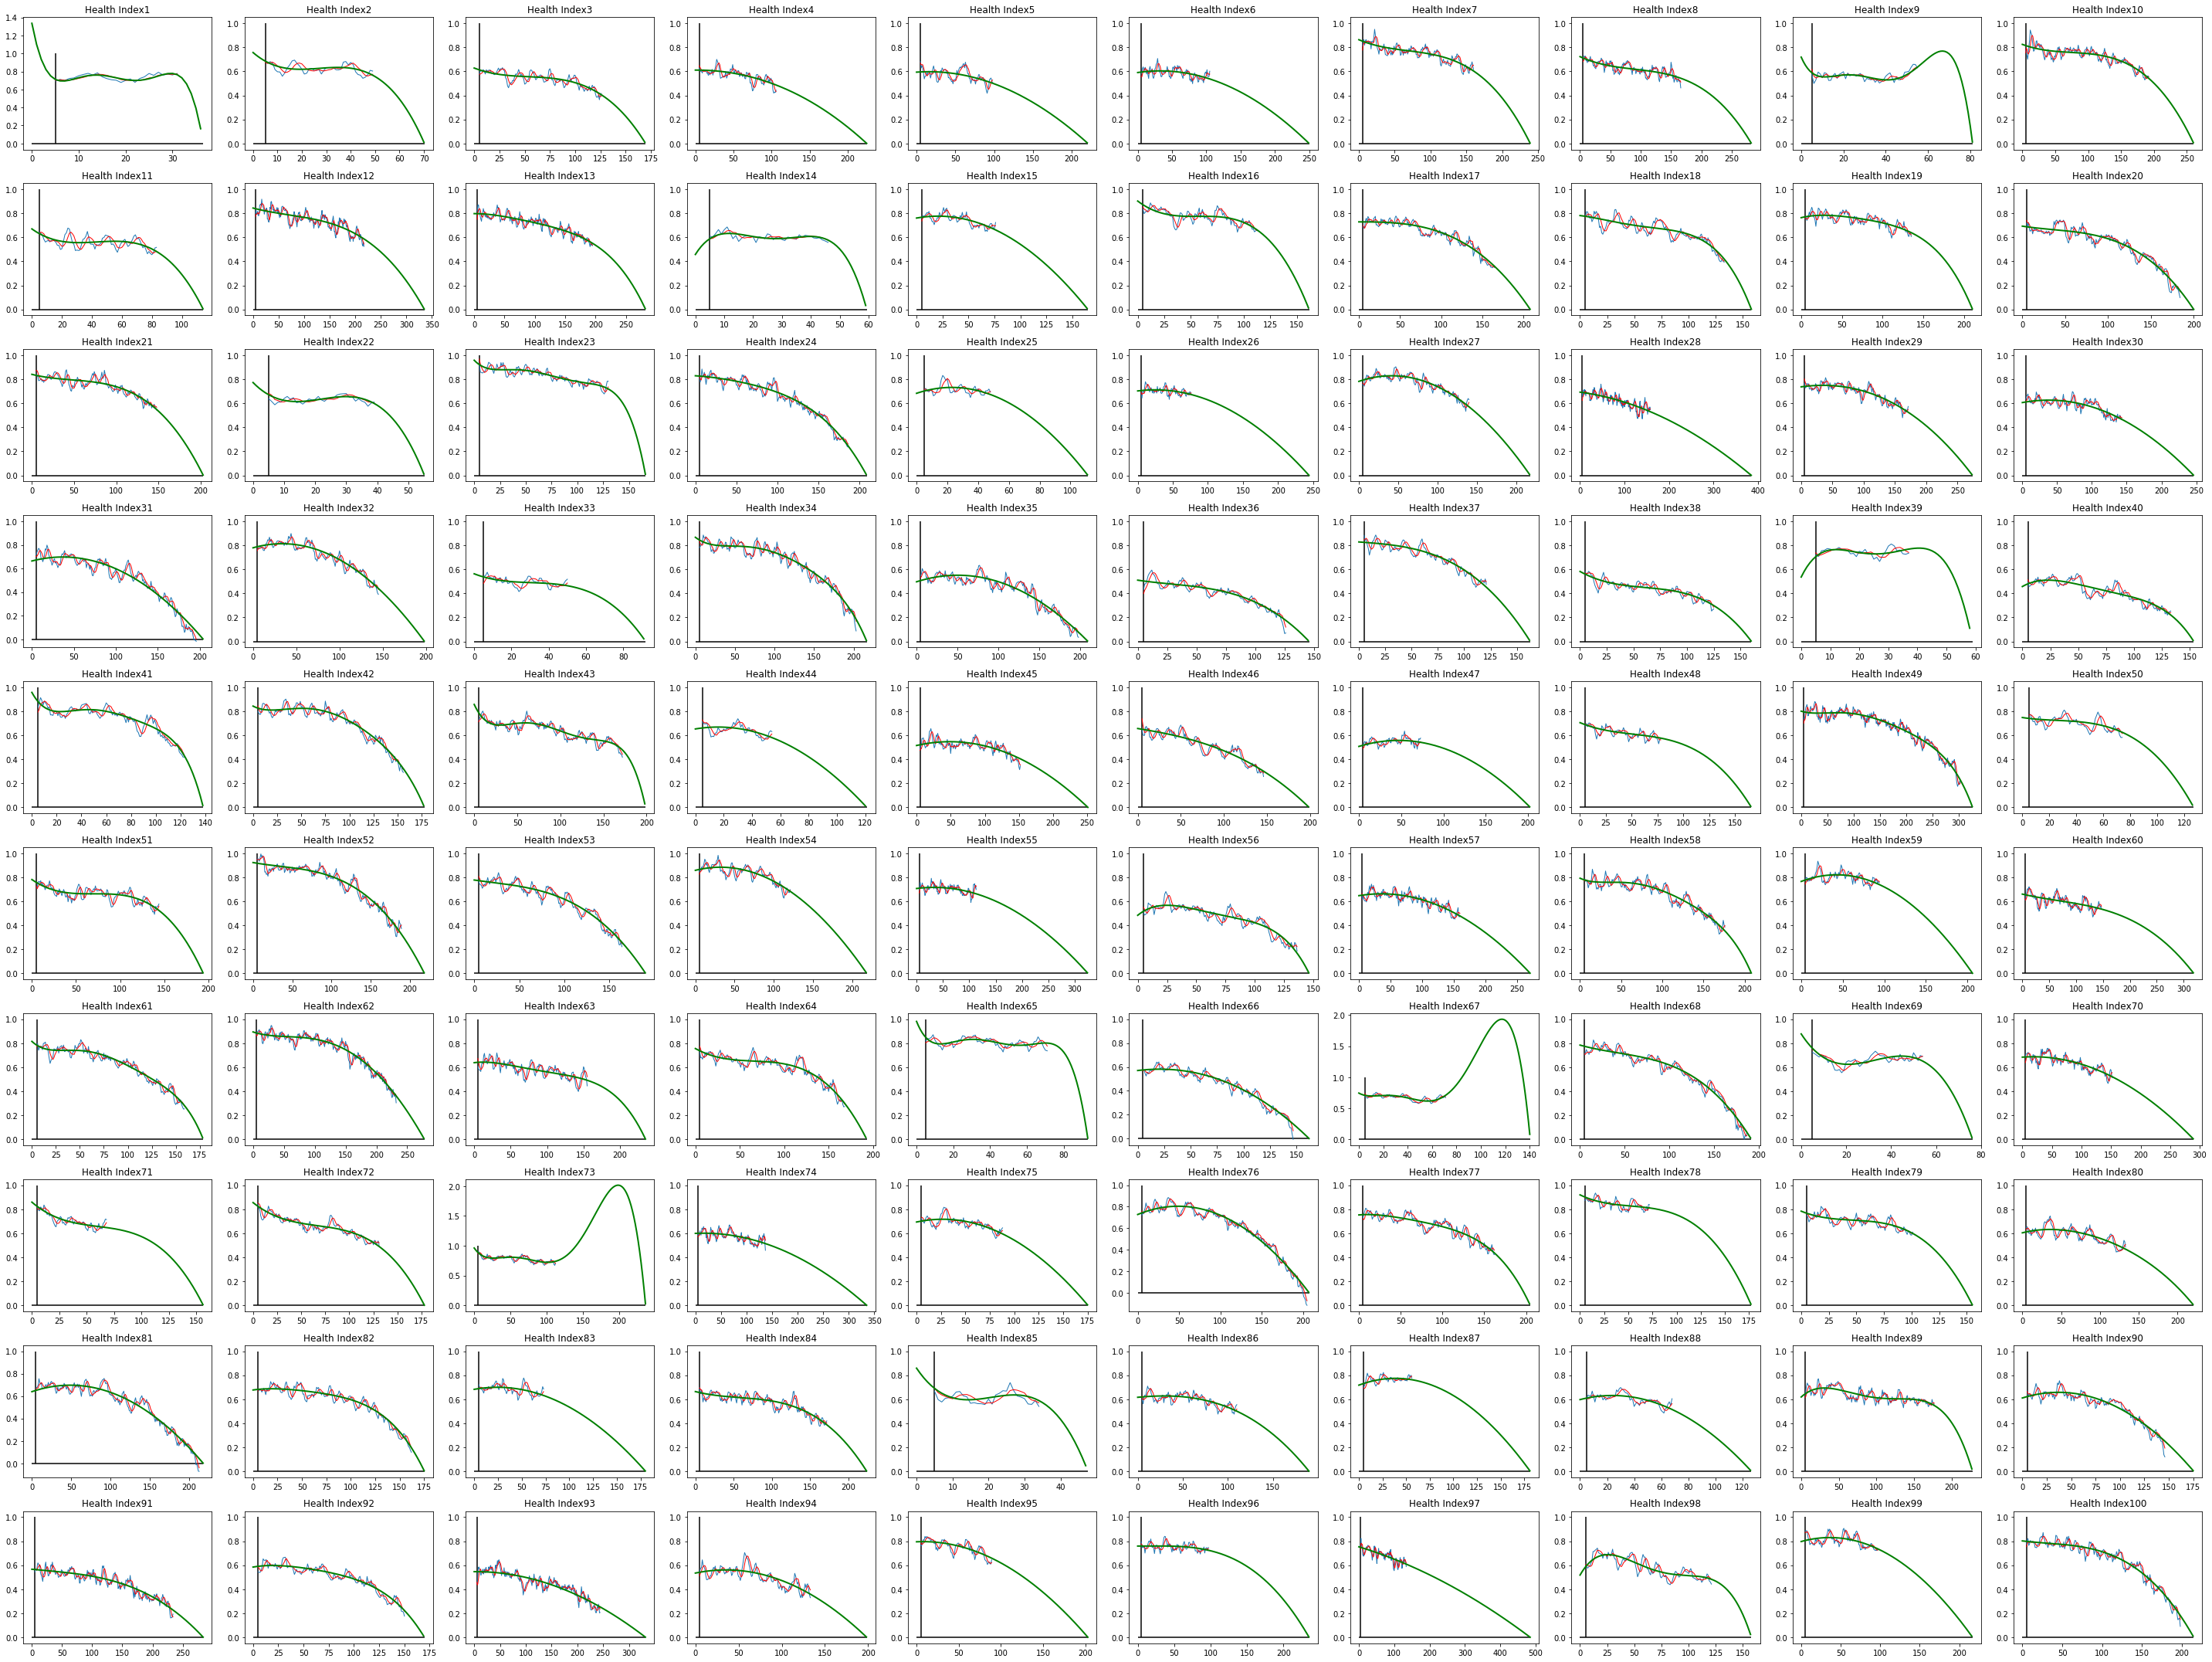

In [48]:
# Plotting the polynomial fit

fig,ax = plt.subplots(10,10,figsize = (40,30))
c = 1
for i in range(0,10):
    for j in range(0,10):
        
        df_u1 = rdf_val.query('unit_nr=='+str(c))
        ax[i,j].plot(df_u1['time'],df_u1.HI.values,linewidth = 1)
        ax[i,j].plot(df_u1['time'],df_u1.MA_HI.values,linewidth = 1,color = 'r')
        
        #Fitting the polynomial
        poly_params = np.polyfit(df_u1['time'], df_u1['MA_HI'], metric_poly.Degree[c-1])   #Fit the data to the polynomial
        poly_1 = np.poly1d(poly_params)                             #Consruct the polynomial
        
        xPoly = np.arange(0,metric_poly.Polynomial_root.iloc[c-1])                # Generate 100 x-coordinates from 0 to max(x)
        yPoly = poly_1(xPoly)                    # Use the polynomial to calculate the y-coordinates
        
        #Plotting the Polynomial
        ax[i,j].plot(np.arange(0,metric_poly.Polynomial_root.iloc[c-1]),yPoly,linewidth = 2,color = 'g')
        ax[i,j].set_title('Health Index'+str(c))
        
        ax[i,j].vlines(min(df_u1['time']),0,1)
        ax[i,j].hlines(0,0,metric_poly.Polynomial_root.iloc[c-1])
        c += 1
        
plt.tight_layout()